# Iowa Liquor Sales Projections

## Initialize Python

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error,median_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics


import random

%matplotlib inline

## 2015 Data: Import & Inspect 

In [205]:
path = '/Users/mjschillawski/Google Drive/Data/generalassembly/data/'
filename = 'iowa_liquor_sales_proj_2.csv'

## Load the data into a DataFrame
data = pd.read_csv(path+filename)

## Transform the dates if needed, e.g.
data["Date"] = pd.to_datetime(data["Date"])

/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [206]:
def DataInspect(dataframe):
    '''Original function (previously called eda) created by Ritika Bhasker
       Good first step when starting any project. Provides overview of
       dataset including missing values, duplicates and types.
       Takes a Pandas dataframe as the argument.
       Modified by Michael Schillawski based on his preferences.'''
    print("Dataframe Shape:", dataframe.shape,"\n")
    print("Duplicate Rows:", dataframe.duplicated().sum(),"\n") #Added this
    print("Dataframe Types \n\n", dataframe.dtypes,"\n")    
    print("Missing Values \n\n", dataframe.isnull().sum(),"\n")
    print("Dataframe Describe \n\n", dataframe.describe(include='all'),"\n")


    print('Unique Values by Variable')
    for item in dataframe:
        print(item,':',dataframe[item].nunique())

In [207]:
DataInspect(data)

Dataframe Shape: (2709552, 24) 

Duplicate Rows: 0 

Dataframe Types 

 Invoice/Item Number              object
Date                     datetime64[ns]
Store Number                      int64
Store Name                       object
Address                          object
City                             object
Zip Code                         object
Store Location                   object
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                     int64
Vendor Name                      object
Item Number                       int64
Item Description                 object
Pack                              int64
Bottle Volume (ml)                int64
State Bottle Cost                object
State Bottle Retail              object
Bottles Sold                      int64
Sale (Dollars)                   object
Volume Sold (Liters)            float64
Volume S

Invoice/Item Number : 2709552
Date : 284
Store Number : 1403
Store Name : 1397
Address : 1398
City : 386
Zip Code : 743
Store Location : 1745
County Number : 99
County : 99
Category : 89
Category Name : 73
Vendor Number : 159
Vendor Name : 160
Item Number : 3865
Item Description : 3029
Pack : 19
Bottle Volume (ml) : 34
State Bottle Cost : 1471
State Bottle Retail : 1525
Bottles Sold : 275
Sale (Dollars) : 11456
Volume Sold (Liters) : 544
Volume Sold (Gallons) : 538


In [208]:
data.rename(columns={'Date':'date', 'Store Number':'storenum', 'City':'city', 
                     'Zip Code':'zipcode', 'County Number':'countynum', 
                     'County':'county',
                     'Category':'category', 'Category Name':'categoryname', 
                     'Vendor Number':'vendornum',
                     'Item Number':'itemnum','Item Description':'itemdescription', 
                     'Bottle Volume (ml)':'bottlevol_ml', 
                     'State Bottle Cost':'statebottlecost',
                     'State Bottle Retail':'statebottleretail', 
                     'Bottles Sold':'bottlessold', 
                     'Sale (Dollars)':'sale_dollars',
                     'Volume Sold (Liters)':'volsold_liters', 
                     'Volume Sold (Gallons)':'volsold_gallons'},inplace=True)

In [209]:
#Drop duplicate rows

def dropduplicates(df):
    print('Original shape:',df.shape)
    temp =  df.drop(df[df.duplicated()].index,axis=0)
    print('Dropped duplicates, new shape: ',temp.shape)
    return temp

data = dropduplicates(data)

Original shape: (2709552, 24)
Dropped duplicates, new shape:  (2709552, 24)


In [210]:
#Remove dollar signs and convert to numeric

bad_col = ['statebottlecost','statebottleretail','sale_dollars']

for item in bad_col:
    data[item] = data[item].str.replace('$','')
    data[item] = data[item].apply(pd.to_numeric)
    
data.head()

,Invoice/Item Number,date,storenum,Store Name,Address,city,zipcode,Store Location,countynum,county,...,itemnum,itemdescription,Pack,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
0,S29198800001,2015-11-20,2191,Keokuk Spirits,1013 MAIN,KEOKUK,52632,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",56.0,Lee,...,297,Templeton Rye w/Flask,6,750,18.09,27.14,6,162.84,4.50,1.19
1,S29195400002,2015-11-21,2205,Ding's Honk And Holler,900 E WASHINGTON,CLARINDA,51632,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",73.0,Page,...,297,Templeton Rye w/Flask,6,750,18.09,27.14,12,325.68,9.00,2.38
2,S29050300001,2015-11-16,3549,Quicker Liquor Store,1414 48TH ST,FORT MADISON,52627,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",56.0,Lee,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,6.40,9.60,2,19.20,0.30,0.08
3,S28867700001,2015-11-04,2513,Hy-Vee Food Store #2 / Iowa City,812 S 1ST AVE,IOWA CITY,52240,812 S 1ST AVE\nIOWA CITY 52240\n,52.0,Johnson,...,237,Knob Creek w/ Crystal Decanter,3,1750,35.55,53.34,3,160.02,5.25,1.39
4,S29050800001,2015-11-17,3942,Twin Town Liquor,104 HIGHWAY 30 WEST,TOLEDO,52342,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",86.0,Tama,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,6.40,9.60,2,19.20,0.30,0.08


In [211]:
DataInspect(data)

Dataframe Shape: (2709552, 24) 

Duplicate Rows: 0 

Dataframe Types 

 Invoice/Item Number            object
date                   datetime64[ns]
storenum                        int64
Store Name                     object
Address                        object
city                           object
zipcode                        object
Store Location                 object
countynum                     float64
county                         object
category                      float64
categoryname                   object
vendornum                       int64
Vendor Name                    object
itemnum                         int64
itemdescription                object
Pack                            int64
bottlevol_ml                    int64
statebottlecost               float64
statebottleretail             float64
bottlessold                     int64
sale_dollars                  float64
volsold_liters                float64
volsold_gallons               float64
dtype: object 



In [212]:
data.drop(['Invoice/Item Number','Store Name','Address',
           'Store Location','vendornum','Vendor Name','Pack'],axis=1,inplace=True)
data.shape

(2709552, 17)

## 2015 Data: Impute missing data

In [213]:
#Extract unique City/Zipcode/CountyNum/County tuples from list
#Drop if CountyNum and County are null
#https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/

##change this
counties = data[data[['city','zipcode','countynum',
                      'county']].duplicated()==False][['city','zipcode',
                                                       'countynum','county']]
counties = counties[counties['countynum'].notnull() & counties['county'].notnull()]
counties['county'].nunique()

99

In [214]:
#Check for duplicated City/Zipcode tuples assigned to multiple counties.
counties[counties.duplicated(['city','zipcode'],False)].sort_values('city')

,city,zipcode,countynum,county
290,ACKLEY,50601,42.0,Hardin
23260,ACKLEY,50601,94.0,Webster
2392677,BETTENDORF,52722,82.0,Scott
2397595,BETTENDORF,52722,48.0,Iowa
254,BETTENDORF,52722,82.0,Scott
678,BETTENDORF,52722,48.0,Iowa
2394018,CLIVE,50325,25.0,Dallas
2397310,CLIVE,50325,77.0,Polk
1682,CLIVE,50325,25.0,Dallas
420,CLIVE,50325,77.0,Polk


In [215]:
full_missing = data[np.logical_and(data['countynum'].isnull(), data['county'].isnull())]
print(len(full_missing))
missing_deduped = full_missing[full_missing[['storenum','city','zipcode',
                        'countynum','county']].duplicated()==False][['storenum',
                                                                     'city','zipcode','countynum','county']]
missing_deduped.head()
print(len(missing_deduped))

10913
65


In [216]:
#Identify list of unique stores missing County, Countynum
#THEN:
##Check for other records from store with county, countynum not missing --> replace for all store records
#THEN:
##Check for other city/zip matches
###IF only 1 county returned --> replace for all store records
###ELSE randomly select county --> replace for all store records

random.seed(19871006)

#First, find the set of data missing county and countynum
full_missing = data[np.logical_and(data['countynum'].isnull(), data['county'].isnull())]

start = len(full_missing)
print('Missing values:',start)

#Second, dedupe the list to find the unique stores missing those data
missing_deduped = full_missing[full_missing[['storenum','city','zipcode',
                        'countynum','county']].duplicated()==False][['storenum',
                                                                     'city','zipcode','countynum','county']]

#initialize counters
store_match = 0
exact_county_match = 0
hotdeck = 0
no_match = 0

#iterate over deduped list
for i in range(len(missing_deduped)):
    
    new_county = ''
    new_countynum = ''
    
    #scan full dataset for other store records
    temp_county = data[data['storenum']==missing_deduped.iat[i,0]]['county'].value_counts()
    
    #if value_counts has non-null values, will return shape >= 1
    #if shape equals 1, we can grab the store's correct county, countynum and replace it
    if temp_county.shape[0] == 1:
        new_county = temp_county.index[0]
        
        temp_countynum = data[data['storenum']==missing_deduped.iat[i,0]]['countynum'].value_counts()
        new_countynum = temp_countynum.index[0]
        

        #get the index of the records with missing county, countynum that match the storenum
        #update those records with the correct data
        for n in full_missing[full_missing['storenum']==missing_deduped.iat[i,0]].index:
            data.iat[n,4] = new_countynum
            data.iat[n,5] = new_county
            
            store_match += 1
    
    
    else:
        #pull out important keys
        index = i
        store_missing = missing_deduped.iat[i,0]
        city_missing = missing_deduped.iat[i,1]
        zipcode_missing = missing_deduped.iat[i,2]
        
        #print('string:',store_missing,city_missing,zipcode_missing)
        
        #define set of possible replacement values
        replacement = counties[(counties['city']==city_missing) & 
                                (counties['zipcode']==zipcode_missing)]
        #print(replacement.head())

        #if only 1 possible replacement, set new values for all records with storenum
        if len(replacement) == 1:
            new_countynum = replacement.iat[0,2]
            new_county = replacement.iat[0,3]

            for n in full_missing[full_missing['storenum']==missing_deduped.iat[i,0]].index:
                data.iat[n,4] = new_countynum
                data.iat[n,5] = new_county

                exact_county_match += 1

        #if more than 1 possible replacement, randomly select 1 value, apply to all records with storenum
        elif len(replacement) > 1:
            srs = replacement.sample(1,axis=0)
            new_countynum = srs.iat[0,1]
            new_county = srs.iat[0,2]

            for n in full_missing[full_missing['storenum']==missing_deduped.iat[i,0]].index:
                data.iat[n,4] = new_countynum
                data.iat[n,5] = new_county

                hotdeck += 1
        
        else:
            print('')
            print('No matches found. Cannot impute.')
            print(store_missing,city_missing,zipcode_missing)
            no_match += 1

#change this
end = len(data[np.logical_and(data['countynum'].isnull(), data['county'].isnull())])

print('')
print('*** Imputation Report ***')
print('')
print('Remaining null values:',end)
print('Filled by from other records from same store:',store_match)
print('Filled by exact county match by city/zip:',exact_county_match)
print('Filled by hotdecking:',hotdeck)
print('No matches found:',no_match)
print('')
print('***end***')

Missing values: 10913

No matches found. Cannot impute.
5217 SEYMOUR 52590

No matches found. Cannot impute.
5217 SEYMOUR 52590

No matches found. Cannot impute.
5232 AUDUBON 50025

No matches found. Cannot impute.
5223 TABOR 51653

No matches found. Cannot impute.
5216 RUNNELLS 50237

*** Imputation Report ***

Remaining null values: 225
Filled by from other records from same store: 13893
Filled by exact county match by city/zip: 4094
Filled by hotdecking: 60
No matches found: 5

***end***


## 2015 Data: Subset out 2016 data

In [217]:
#subset 2016 data
#for predictions later
print(data.shape)
test2016 = data[data['date'] > '2015-12-31']
print(test2016.shape)

#isolate 2016 data from 2015 training data
train2015 = data[data['date'] < '2016-01-01']
print(train2015.shape)

print(test2016.shape[0] + train2015.shape[0])

(2709552, 17)
(525069, 17)
(2184483, 17)
2709552


In [218]:
print(train2015['date'].describe())
print('')
print(test2016['date'].describe())

count                 2184483
unique                    227
top       2015-12-01 00:00:00
freq                    15588
first     2015-01-05 00:00:00
last      2015-12-31 00:00:00
Name: date, dtype: object

count                  525069
unique                     57
top       2016-01-04 00:00:00
freq                    13251
first     2016-01-04 00:00:00
last      2016-03-31 00:00:00
Name: date, dtype: object


## 2015 Data: Transformations

In [219]:
#Annual 2015 totals by store
stores2015 = train2015.groupby('storenum')[['bottlevol_ml','statebottlecost',
                                            'statebottleretail','bottlessold',
                                            'sale_dollars','volsold_liters',
                                            'volsold_gallons']].sum()
stores2015.head()

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
storenum,,,,,,,
2106,4643675,55183.96,82829.51,99998,1434369.85,93986.47,24832.44
2113,1313875,14469.12,21725.74,6483,85763.42,6500.83,1717.17
2130,3647275,40580.91,60908.96,72562,1108184.99,65562.88,17321.29
2152,1513250,12311.88,18507.48,5928,72080.36,6164.92,1628.42
2178,2739775,26665.46,40070.07,20504,277987.96,21719.49,5737.98


In [220]:
##define target vector
y2015 = stores2015[['sale_dollars']]
y2015.head()

,sale_dollars
storenum,
2106,1434369.85
2113,85763.42
2130,1108184.99
2152,72080.36
2178,277987.96


In [221]:
#2015 County Report
county2015 = train2015.groupby('county')[['bottlevol_ml','statebottlecost',
                                          'statebottleretail','bottlessold',
                                          'sale_dollars','volsold_liters',
                                          'volsold_gallons']].sum()
county2015.head()

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
county,,,,,,,
Adair,4476500,40309.73,60565.89,35049,424750.82,33957.85,8969.34
Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,1992.02
Allamakee,9149175,85870.70,128995.45,60923,823579.28,66221.26,17492.56
Appanoose,8427750,83137.76,124862.60,67033,835381.93,61519.26,16252.01
Audubon,2066300,17855.24,26836.31,15202,173849.23,14856.43,3925.72


In [222]:
county2015['sale_dollars'].sum()

284328572.1100367

In [223]:
county2015[(county2015['sale_dollars'] > 20000000) &
           county2015['sale_dollars']].sort_values('sale_dollars',ascending=False)

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
county,,,,,,,
Polk,349099665,4.045211e+06,6.074546e+06,4700900,6.374812e+07,4068202.31,1.074891e+06
Linn,162720502,1.804386e+06,2.709622e+06,1960733,2.498995e+07,1745282.80,4.610946e+05
Scott,116571452,1.297286e+06,1.948043e+06,1664924,2.042237e+07,1321884.84,3.492656e+05


In [224]:
county2015[(county2015['sale_dollars'] < 20000000) &
           (county2015['sale_dollars'] > 10000000)].sort_values('sale_dollars',ascending=False)

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
county,,,,,,,
Johnson,97168593,1130907.56,1.698245e+06,1246902,1.767330e+07,1111586.58,293679.73
Black Hawk,103445927,1136855.11,1.707306e+06,1404315,1.606455e+07,1081027.23,285628.51
Woodbury,62845287,690650.75,1.037047e+06,764809,1.011524e+07,672705.54,177738.15
Pottawattamie,65785362,697351.70,1.047036e+06,765553,1.005684e+07,677164.38,178914.28


In [225]:
county2015[(county2015['sale_dollars'] < 10000000) &
           (county2015['sale_dollars'] > 1000000)].sort_values('sale_dollars',ascending=False).count()

bottlevol_ml         38
statebottlecost      38
statebottleretail    38
bottlessold          38
sale_dollars         38
volsold_liters       38
volsold_gallons      38
dtype: int64

In [226]:
county2015[(county2015['sale_dollars'] < 1000000) &
           (county2015['sale_dollars'] > 500000)].sort_values('sale_dollars',ascending=False).count()

bottlevol_ml         28
statebottlecost      28
statebottleretail    28
bottlessold          28
sale_dollars         28
volsold_liters       28
volsold_gallons      28
dtype: int64

In [227]:
county2015[(county2015['sale_dollars'] < 500000)].sort_values('sale_dollars',ascending=False).count()

bottlevol_ml         26
statebottlecost      26
statebottleretail    26
bottlessold          26
sale_dollars         26
volsold_liters       26
volsold_gallons      26
dtype: int64

### ^^ USE THIS FOR 2015 YEARLY LIQUOR SALES ^^

In [228]:
#https://stackoverflow.com/questions/44908383/how-can-i-group-by-month-from-a-date-field-using-python-pandas
#Transform store-level aggregation into store/month aggregation
storesmonth2015 = train2015.groupby([train2015['date'].dt.strftime('%B'),
                                     'storenum'])[['bottlevol_ml','statebottlecost',
                                                   'statebottleretail','bottlessold',
                                                   'sale_dollars','volsold_liters',
                                                   'volsold_gallons']].sum().reset_index()
storesmonth2015.head()

,date,storenum,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
0,April,2106,472675,5510.52,8269.40,10328,145102.74,9736.75,2572.57
1,April,2113,95375,956.81,1438.11,522,6583.76,517.10,136.61
2,April,2130,371125,4219.29,6332.68,7820,116671.10,6919.60,1828.12
3,April,2152,136750,1010.64,1518.38,549,6315.64,579.62,153.10
4,April,2178,256675,2421.43,3635.75,1808,25255.84,1936.12,511.49


In [229]:
#unstack month index to make wide
monthly2015 = storesmonth2015.pivot(index='storenum',columns='date')
monthly2015.columns
monthly2015.head()

bottlevol_ml                                                    \
date            April    August  December  February   January      July   
storenum                                                                  
2106         472675.0  348300.0  439850.0  357800.0  354975.0  388450.0   
2113          95375.0   84750.0  157500.0   86750.0  116750.0   89875.0   
2130         371125.0  257975.0  358350.0  278025.0  279925.0  358550.0   
2152         136750.0  139875.0  125000.0  122625.0  123500.0  158750.0   
2178         256675.0  239100.0  308775.0  195400.0  183425.0  212775.0   

                                                    ...    volsold_gallons  \
date          June     March       May  November    ...           December   
storenum                                            ...                      
2106      369300.0  373150.0  385550.0  325450.0    ...            2337.14   
2113      121125.0  116125.0  119750.0   99500.0    ...             202.90   
2130      279950.0  311625.0  260400.0  277925.0    ...            1660.77   
2152      121000.0  109375.0   97250.0  110000.0    ...             124.51   
2178      282475.0  177375.0  257800.0  215550.0    ...             647.94   

                                                                         \
date     February  January     July     June    March      May November   
storenum                                                                  
2106      1937.11  1880.39  2007.48  1912.15  1946.54  2064.02  1727.98   
2113       125.72   149.68   130.79   172.20   148.33   165.53    98.93   
2130      1554.18  1146.09  1666.08  1330.05  1573.33  1197.74  1405.29   
2152       129.83   128.07   189.75   143.02   115.75   120.10   105.08   
2178       360.06   384.29   454.47   541.36   411.77   593.61   368.75   

                             
date      October September  
storenum                     
2106      2681.97   1943.16  
2113       131.64    152.72  
2130      1631.08   1111.75  
2152       139.99    134.28  
2178       543.71    446.58  

[5 rows x 84 columns]

In [230]:
#collapse index
#https://stackoverflow.com/questions/22779516/unstack-multiindex-dataframe-to-flat-data-frame-in-pandas
monthlystores2015 = pd.DataFrame(monthly2015.to_records())
monthlystores2015.head()

,storenum,"('bottlevol_ml', 'April')","('bottlevol_ml', 'August')","('bottlevol_ml', 'December')","('bottlevol_ml', 'February')","('bottlevol_ml', 'January')","('bottlevol_ml', 'July')","('bottlevol_ml', 'June')","('bottlevol_ml', 'March')","('bottlevol_ml', 'May')",...,"('volsold_gallons', 'December')","('volsold_gallons', 'February')","('volsold_gallons', 'January')","('volsold_gallons', 'July')","('volsold_gallons', 'June')","('volsold_gallons', 'March')","('volsold_gallons', 'May')","('volsold_gallons', 'November')","('volsold_gallons', 'October')","('volsold_gallons', 'September')"
0,2106,472675.0,348300.0,439850.0,357800.0,354975.0,388450.0,369300.0,373150.0,385550.0,...,2337.14,1937.11,1880.39,2007.48,1912.15,1946.54,2064.02,1727.98,2681.97,1943.16
1,2113,95375.0,84750.0,157500.0,86750.0,116750.0,89875.0,121125.0,116125.0,119750.0,...,202.90,125.72,149.68,130.79,172.20,148.33,165.53,98.93,131.64,152.72
2,2130,371125.0,257975.0,358350.0,278025.0,279925.0,358550.0,279950.0,311625.0,260400.0,...,1660.77,1554.18,1146.09,1666.08,1330.05,1573.33,1197.74,1405.29,1631.08,1111.75
3,2152,136750.0,139875.0,125000.0,122625.0,123500.0,158750.0,121000.0,109375.0,97250.0,...,124.51,129.83,128.07,189.75,143.02,115.75,120.10,105.08,139.99,134.28
4,2178,256675.0,239100.0,308775.0,195400.0,183425.0,212775.0,282475.0,177375.0,257800.0,...,647.94,360.06,384.29,454.47,541.36,411.77,593.61,368.75,543.71,446.58


In [231]:
monthlystores2015.columns

Index(['storenum', '('bottlevol_ml', 'April')', '('bottlevol_ml', 'August')',
       '('bottlevol_ml', 'December')', '('bottlevol_ml', 'February')',
       '('bottlevol_ml', 'January')', '('bottlevol_ml', 'July')',
       '('bottlevol_ml', 'June')', '('bottlevol_ml', 'March')',
       '('bottlevol_ml', 'May')', '('bottlevol_ml', 'November')',
       '('bottlevol_ml', 'October')', '('bottlevol_ml', 'September')',
       '('statebottlecost', 'April')', '('statebottlecost', 'August')',
       '('statebottlecost', 'December')', '('statebottlecost', 'February')',
       '('statebottlecost', 'January')', '('statebottlecost', 'July')',
       '('statebottlecost', 'June')', '('statebottlecost', 'March')',
       '('statebottlecost', 'May')', '('statebottlecost', 'November')',
       '('statebottlecost', 'October')', '('statebottlecost', 'September')',
       '('statebottleretail', 'April')', '('statebottleretail', 'August')',
       '('statebottleretail', 'December')',
       '('statebottleret

In [232]:
#keep only sales data
ms_sales2015 = monthlystores2015[['storenum',"('sale_dollars', 'August')", "('sale_dollars', 'December')",
       "('sale_dollars', 'February')", "('sale_dollars', 'January')",
       "('sale_dollars', 'July')", "('sale_dollars', 'June')",
       "('sale_dollars', 'March')", "('sale_dollars', 'May')",
       "('sale_dollars', 'November')", "('sale_dollars', 'October')",
       "('sale_dollars', 'September')","('sale_dollars', 'April')"]]
ms_sales2015.head()

,storenum,"('sale_dollars', 'August')","('sale_dollars', 'December')","('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'July')","('sale_dollars', 'June')","('sale_dollars', 'March')","('sale_dollars', 'May')","('sale_dollars', 'November')","('sale_dollars', 'October')","('sale_dollars', 'September')","('sale_dollars', 'April')"
0,2106,107201.74,139965.77,115041.01,109795.48,117713.21,110685.44,112330.04,116896.02,97562.38,150977.52,111098.50,145102.74
1,2113,5400.69,9792.06,6418.05,7685.86,5659.08,9001.75,8247.95,7883.05,5074.57,6279.40,7737.20,6583.76
2,2130,77098.45,103863.38,104825.96,71307.51,103251.73,90863.09,101630.99,69911.23,94059.28,105598.58,69103.69,116671.10
3,2152,6608.02,5333.12,5820.09,5746.27,8266.83,6269.00,5238.75,5675.27,4428.02,6202.41,6176.94,6315.64
4,2178,22256.67,33775.19,16602.12,17970.36,21701.67,26125.18,19838.94,26457.94,20539.60,25118.73,22345.72,25255.84


In [233]:
print(ms_sales2015.shape)
print(y2015.shape)

(1375, 13)
(1375, 1)


In [234]:
#merge target vector (annual store sales) on monthly store sales data
ms_sales2015 = pd.merge(ms_sales2015,y2015.reset_index(),on='storenum')
ms_sales2015.shape

(1375, 14)

In [235]:
#drop if sales data not complete
ms_sales2015.dropna(inplace=True)
ms_sales2015.shape

(998, 14)

In [236]:
ms_sales2015.head()

,storenum,"('sale_dollars', 'August')","('sale_dollars', 'December')","('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'July')","('sale_dollars', 'June')","('sale_dollars', 'March')","('sale_dollars', 'May')","('sale_dollars', 'November')","('sale_dollars', 'October')","('sale_dollars', 'September')","('sale_dollars', 'April')",sale_dollars
0,2106,107201.74,139965.77,115041.01,109795.48,117713.21,110685.44,112330.04,116896.02,97562.38,150977.52,111098.50,145102.74,1434369.85
1,2113,5400.69,9792.06,6418.05,7685.86,5659.08,9001.75,8247.95,7883.05,5074.57,6279.40,7737.20,6583.76,85763.42
2,2130,77098.45,103863.38,104825.96,71307.51,103251.73,90863.09,101630.99,69911.23,94059.28,105598.58,69103.69,116671.10,1108184.99
3,2152,6608.02,5333.12,5820.09,5746.27,8266.83,6269.00,5238.75,5675.27,4428.02,6202.41,6176.94,6315.64,72080.36
4,2178,22256.67,33775.19,16602.12,17970.36,21701.67,26125.18,19838.94,26457.94,20539.60,25118.73,22345.72,25255.84,277987.96


## 2015 Data: EDA

In [237]:
#From 3.06 evaluation and cross-validation lab

def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(11,7))

    # Generate a mask for the upper triangle 
    #(taken from the Seaborn example gallery):
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with Seaborn.
    # Assign the matplotlib axis the function returns. 
    #This allow us to resize the labels.
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap=cmap, vmin=-1, vmax=1)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, 
    #it prevents those useless printouts from matplotlib.
    plt.show()

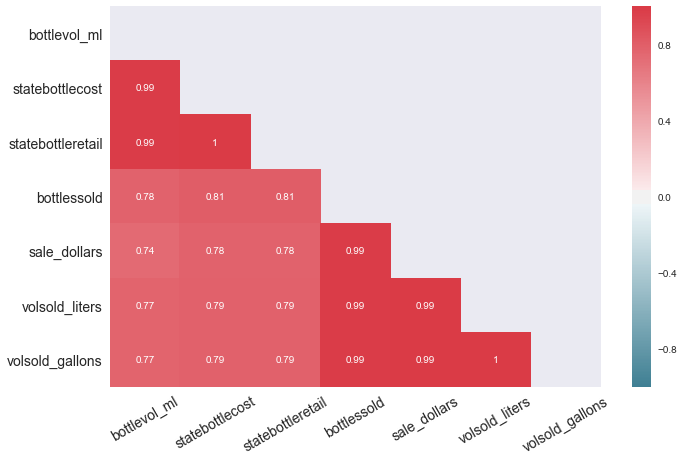

In [238]:
correlation_heat_map(stores2015)

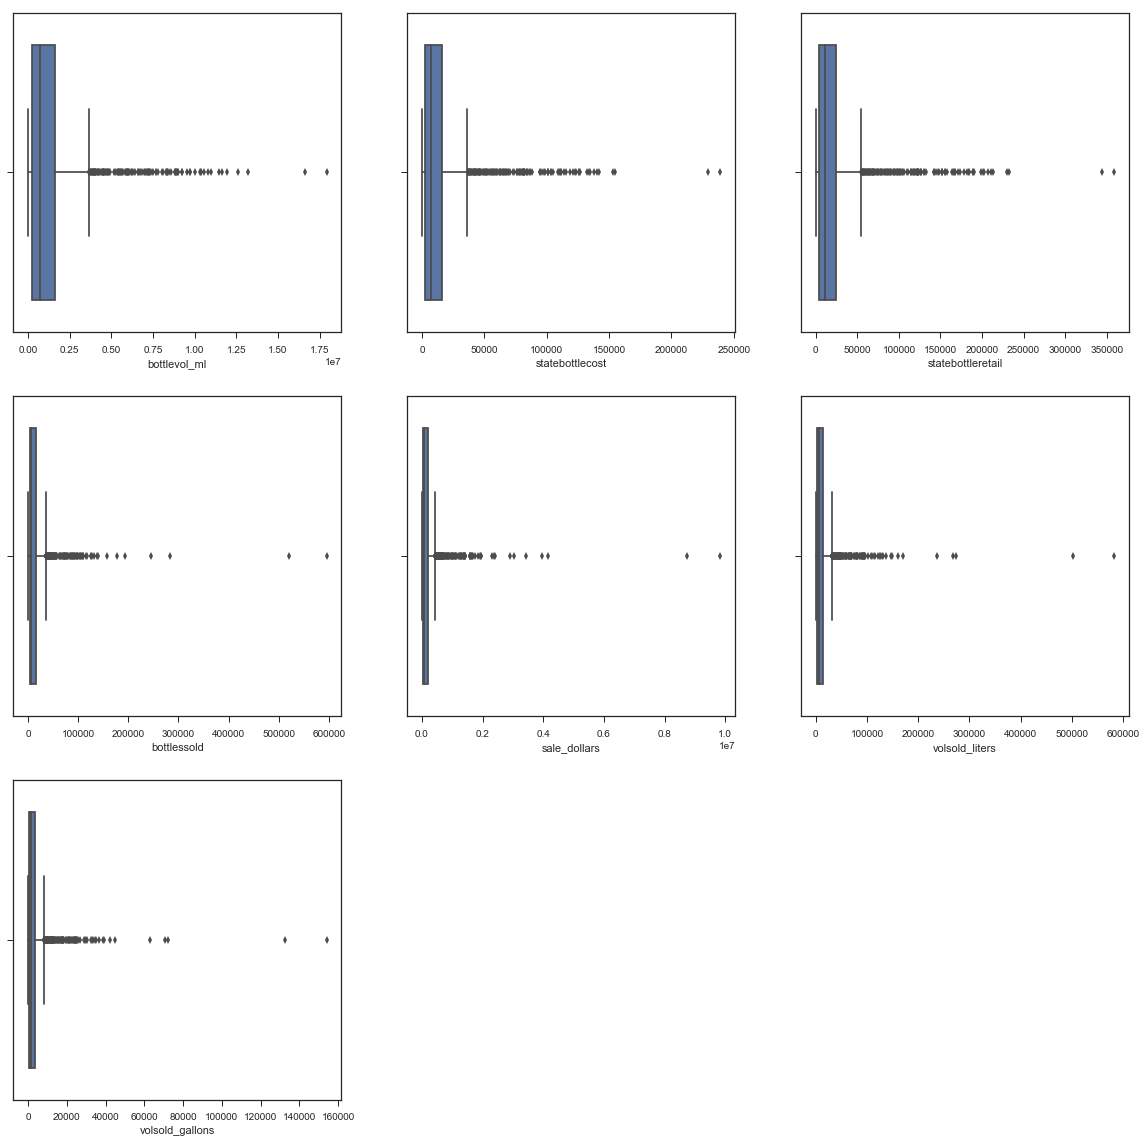

In [239]:
sns.set(style = 'ticks')

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(331)
sns.boxplot(stores2015['bottlevol_ml'])

ax = fig.add_subplot(332)
sns.boxplot(stores2015['statebottlecost'])

ax = fig.add_subplot(333)
sns.boxplot(stores2015['statebottleretail'])

ax = fig.add_subplot(334)
sns.boxplot(stores2015['bottlessold'])

ax = fig.add_subplot(335)
sns.boxplot(stores2015['sale_dollars'])

ax = fig.add_subplot(336)
sns.boxplot(stores2015['volsold_liters'])

ax = fig.add_subplot(337)
sns.boxplot(stores2015['volsold_gallons'])

plt.show()

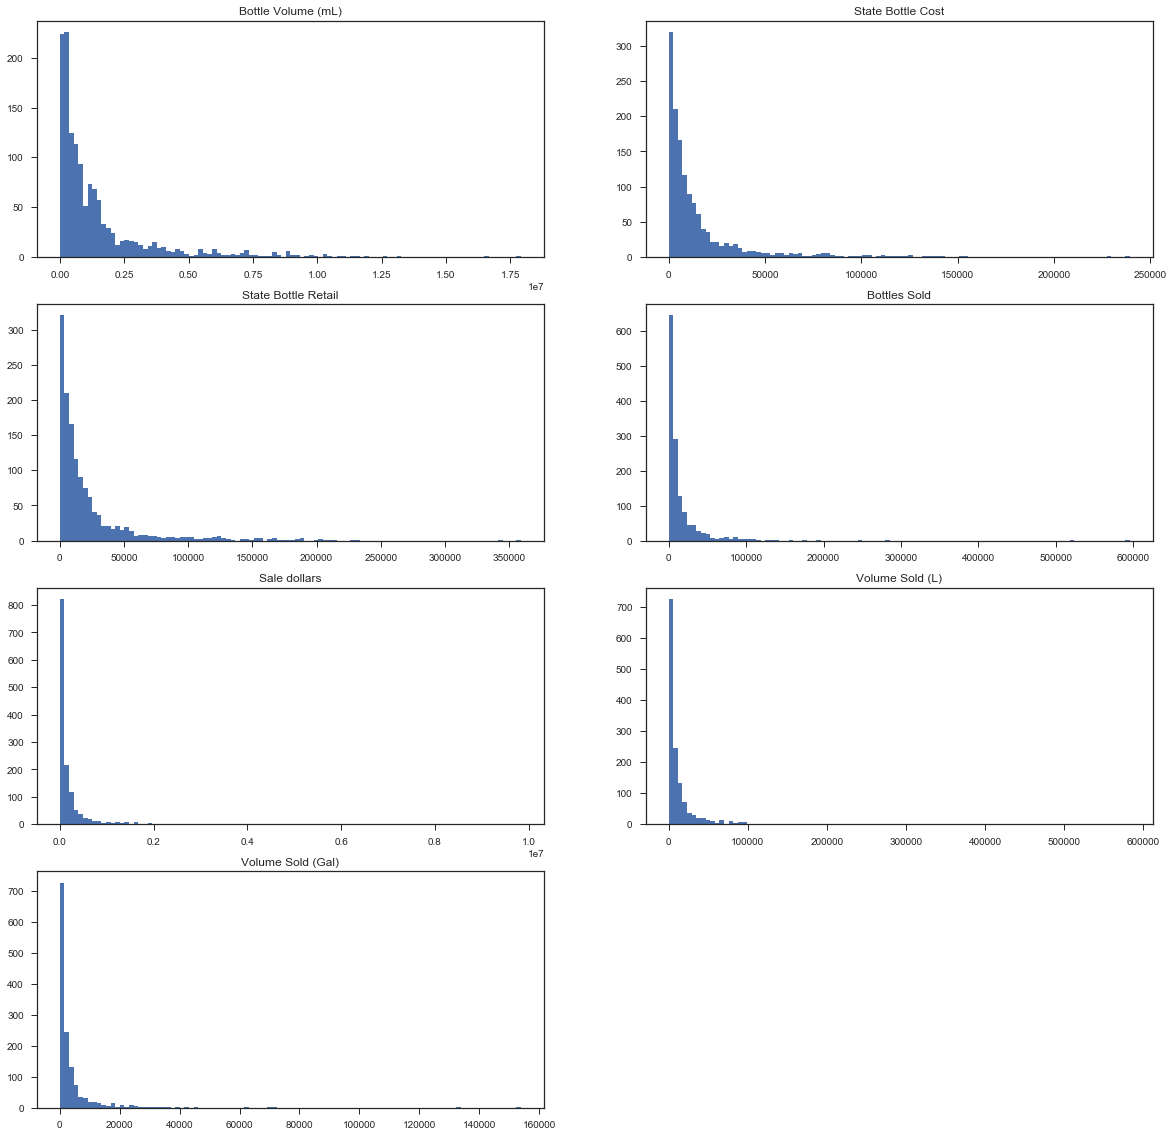

In [240]:
sns.set(style = 'ticks')

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(421)
_ = plt.hist(x=stores2015['bottlevol_ml'],bins=100)
_ = plt.title('Bottle Volume (mL)')

ax = fig.add_subplot(422)
_ = plt.hist(x=stores2015['statebottlecost'],bins=100)
_ = plt.title('State Bottle Cost')

ax = fig.add_subplot(423)
_ = plt.hist(x=stores2015['statebottleretail'],bins=100)
_ = plt.title('State Bottle Retail')

ax = fig.add_subplot(424)
_ = plt.hist(x=stores2015['bottlessold'],bins=100)
_ = plt.title('Bottles Sold')

ax = fig.add_subplot(425)
_ = plt.hist(x=stores2015['sale_dollars'],bins=100)
_ = plt.title('Sale dollars')

ax = fig.add_subplot(426)
_ = plt.hist(x=stores2015['volsold_liters'],bins=100)
_ = plt.title('Volume Sold (L)')

ax = fig.add_subplot(427)
_ = plt.hist(x=stores2015['volsold_gallons'],bins=100)
_ = plt.title('Volume Sold (Gal)')

plt.show()

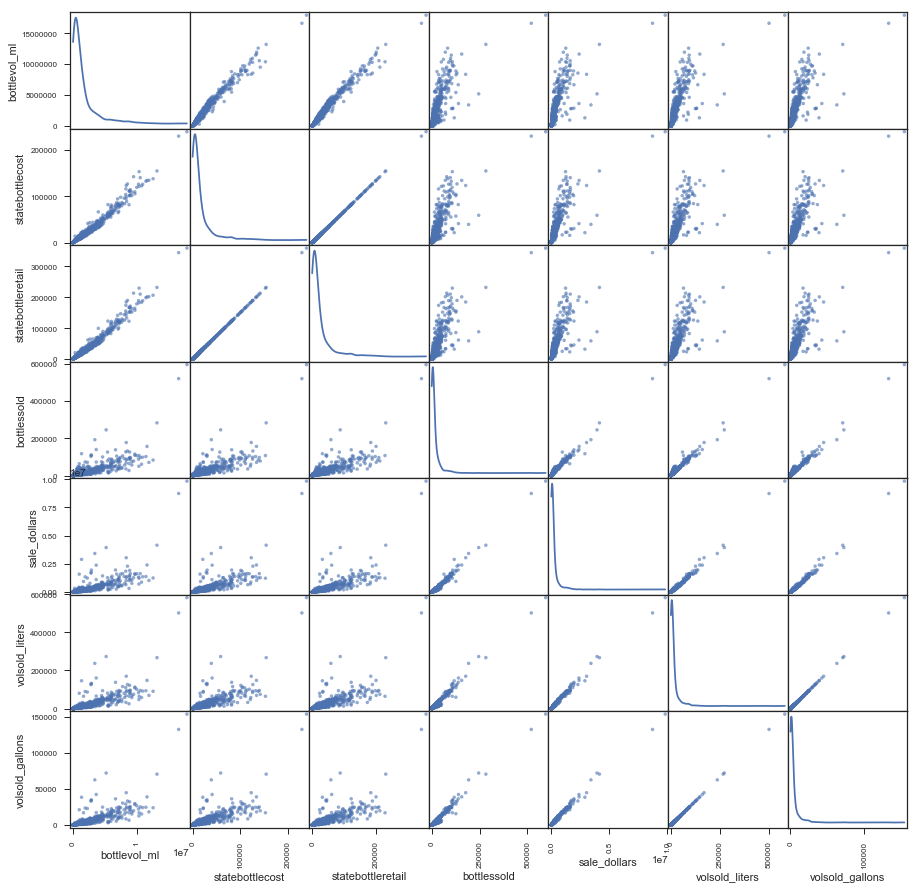

In [241]:
pd.plotting.scatter_matrix(stores2015,alpha=0.6, figsize=(15, 15), diagonal='kde');

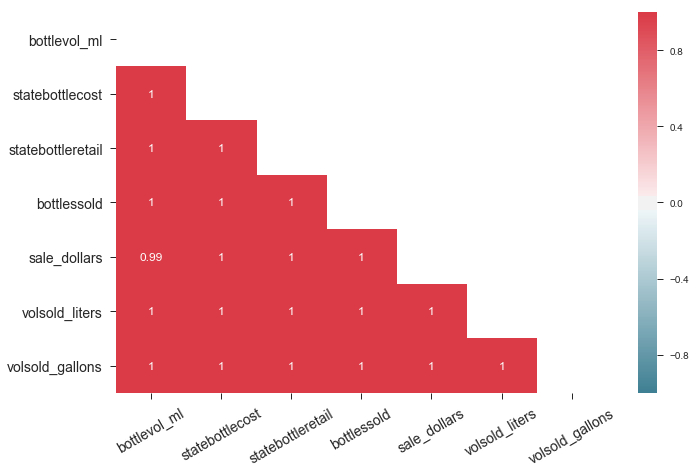

In [242]:
correlation_heat_map(county2015)

In [243]:
first3 = storesmonth2015[storesmonth2015['date'].isin(['January','February','March'])]
first3 = pd.merge(first3,y2015.reset_index(),on='storenum')
first3.rename(columns={'sale_dollars_x':'month_sales',
                       'sale_dollars_y':'annual_sales'},inplace=True)

first3.head()

,date,storenum,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,month_sales,volsold_liters,volsold_gallons,annual_sales
0,February,2106,357800,4525.84,6796.74,7824,115041.01,7331.55,1937.11,1434369.85
1,January,2106,354975,4255.22,6385.68,7580,109795.48,7116.85,1880.39,1434369.85
2,March,2106,373150,4503.87,6761.01,7912,112330.04,7367.15,1946.54,1434369.85
3,February,2113,86750,958.90,1440.86,498,6418.05,475.98,125.72,85763.42
4,January,2113,116750,1272.85,1910.81,571,7685.86,566.74,149.68,85763.42


In [244]:
q1_2015 = first3.groupby('storenum').agg({'month_sales':'sum','annual_sales':'mean'})

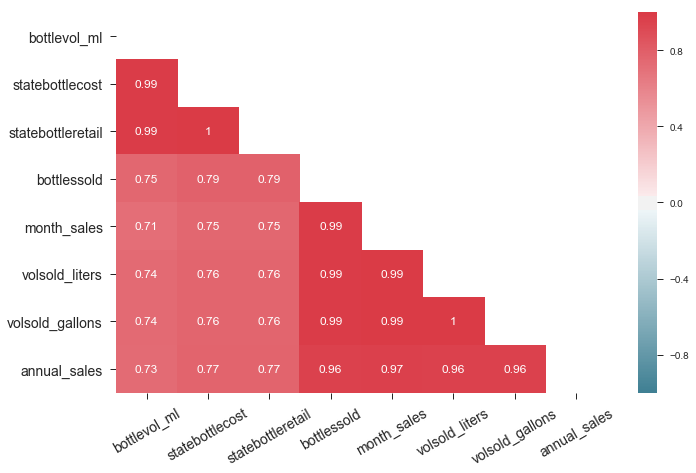

In [245]:
correlation_heat_map(first3.drop('storenum',axis=1))

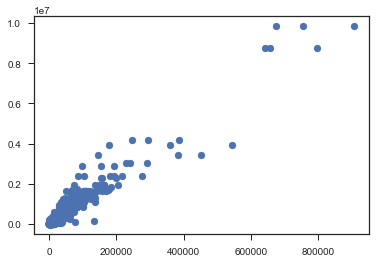

In [246]:
plt.scatter(first3['month_sales'],first3['annual_sales'])

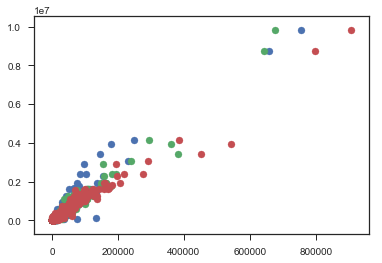

In [247]:
plt.scatter(first3[first3['date']=='January']['month_sales'],
            first3[first3['date']=='January']['annual_sales'])

plt.scatter(first3[first3['date']=='February']['month_sales'],
            first3[first3['date']=='February']['annual_sales'])

plt.scatter(first3[first3['date']=='March']['month_sales'],
            first3[first3['date']=='March']['annual_sales'])

Annual sales is tightly correlated with bottles sold, monthly sales, and volume.
Weaker, but still strong, correlation with bottle_volume, bottle cost, and retail price.

Annual sales nearly perfect correlated with every aspect of annual data.

Couple of likely outliers, probably 1 or 2 stores. Different class entirely. Investigate removing?

Distribution of sales, volume, etc.?

## 2014 Data: Import & Inspect

In [248]:
filename2014 = 'iowa_liquor_2014.csv'

data2014 = pd.read_csv(path+filename2014)

## Transform the dates if needed, e.g.
data2014["date"] = pd.to_datetime(data2014["date"])

data2014.head()

,Unnamed: 0,Invoice/Item Number,date,storenum,Store Name,Address,city,zipcode,Store Location,countynum,...,itemnum,itemdescription,Pack,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
0,108,S17627300143,2014-02-26,2614,Hy-Vee #3 Food and Drugstore,1823 E KIMBERLY RD,DAVENPORT,52807,1823 E KIMBERLY RD\nDAVENPORT 52807\n(41.55678...,82.0,...,15776,Bushmills Irish Whiskey,12,750,$13.00,$19.50,4,$78.00,3.0,0.79
1,112,S18283700037,2014-04-07,2603,Hy-Vee Wine and Spirits / Bettendorf,2890 DEVILS GLEN ROAD,BETTENDORF,52722,2890 DEVILS GLEN ROAD\nBETTENDORF 52722\n(41.5...,82.0,...,30318,Gordon's Gin London Dry - Pet,6,1750,$11.00,$16.49,6,$98.94,10.5,2.77
2,122,S19526900004,2014-06-12,4819,Super Stop 2 / Altoona,2635 ADVENTURELAND DR,ALTOONA,50009,2635 ADVENTURELAND DR\nALTOONA 50009\n(41.6585...,77.0,...,35318,Barton Vodka,6,1750,$6.92,$10.38,6,$62.28,10.5,2.77
3,123,S19153100167,2014-05-23,2515,Hy-Vee Food Store #1 / Mason City,2400 4TH ST SW,MASON CITY,50401,"2400 4TH ST SW\nMASON CITY 50401\n(43.148446, ...",17.0,...,5036,Glenlivet 12 Yr Malt Scotch,12,750,$22.07,$33.11,2,$66.22,1.5,0.40
4,126,S18205200042,2014-04-02,4167,"Iowa Street Market, Inc.",1256 IOWA ST,DUBUQUE,52001,"1256 IOWA ST\nDUBUQUE 52001\n(42.504958, -90.6...",31.0,...,24456,Kessler Blend Whiskey,12,750,$5.51,$8.26,12,$99.12,9.0,2.38


In [249]:
DataInspect(data2014)

Dataframe Shape: (2097796, 25) 

Duplicate Rows: 0 

Dataframe Types 

 Unnamed: 0                      int64
Invoice/Item Number            object
date                   datetime64[ns]
storenum                        int64
Store Name                     object
Address                        object
city                           object
zipcode                        object
Store Location                 object
countynum                     float64
county                         object
category                      float64
categoryname                   object
vendornum                     float64
Vendor Name                    object
itemnum                         int64
itemdescription                object
Pack                            int64
bottlevol_ml                    int64
statebottlecost                object
statebottleretail              object
bottlessold                     int64
sale_dollars                   object
volsold_liters                float64
volsold_gallons 

statebottlecost : 1532
statebottleretail : 1748
bottlessold : 232
sale_dollars : 12062
volsold_liters : 509
volsold_gallons : 504


In [250]:
data2014.rename(columns={'Date':'date', 'Store Number':'storenum', 'City':'city', 
                     'Zip Code':'zipcode', 'County Number':'countynum', 
                     'County':'county',
                     'Category':'category', 'Category Name':'categoryname', 
                     'Vendor Number':'vendornum',
                     'Item Number':'itemnum','Item Description':'itemdescription', 
                     'Bottle Volume (ml)':'bottlevol_ml', 
                     'State Bottle Cost':'statebottlecost',
                     'State Bottle Retail':'statebottleretail', 
                     'Bottles Sold':'bottlessold', 
                     'Sale (Dollars)':'sale_dollars',
                     'Volume Sold (Liters)':'volsold_liters', 
                     'Volume Sold (Gallons)':'volsold_gallons'},inplace=True)

In [251]:
#Remove dollar signs and convert to numeric

bad_col = ['statebottlecost','statebottleretail','sale_dollars']

for item in bad_col:
    data2014[item] = data2014[item].str.replace('$','')
    data2014[item] = data2014[item].apply(pd.to_numeric)
    
data2014.head()

,Unnamed: 0,Invoice/Item Number,date,storenum,Store Name,Address,city,zipcode,Store Location,countynum,...,itemnum,itemdescription,Pack,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
0,108,S17627300143,2014-02-26,2614,Hy-Vee #3 Food and Drugstore,1823 E KIMBERLY RD,DAVENPORT,52807,1823 E KIMBERLY RD\nDAVENPORT 52807\n(41.55678...,82.0,...,15776,Bushmills Irish Whiskey,12,750,13.00,19.50,4,78.00,3.0,0.79
1,112,S18283700037,2014-04-07,2603,Hy-Vee Wine and Spirits / Bettendorf,2890 DEVILS GLEN ROAD,BETTENDORF,52722,2890 DEVILS GLEN ROAD\nBETTENDORF 52722\n(41.5...,82.0,...,30318,Gordon's Gin London Dry - Pet,6,1750,11.00,16.49,6,98.94,10.5,2.77
2,122,S19526900004,2014-06-12,4819,Super Stop 2 / Altoona,2635 ADVENTURELAND DR,ALTOONA,50009,2635 ADVENTURELAND DR\nALTOONA 50009\n(41.6585...,77.0,...,35318,Barton Vodka,6,1750,6.92,10.38,6,62.28,10.5,2.77
3,123,S19153100167,2014-05-23,2515,Hy-Vee Food Store #1 / Mason City,2400 4TH ST SW,MASON CITY,50401,"2400 4TH ST SW\nMASON CITY 50401\n(43.148446, ...",17.0,...,5036,Glenlivet 12 Yr Malt Scotch,12,750,22.07,33.11,2,66.22,1.5,0.40
4,126,S18205200042,2014-04-02,4167,"Iowa Street Market, Inc.",1256 IOWA ST,DUBUQUE,52001,"1256 IOWA ST\nDUBUQUE 52001\n(42.504958, -90.6...",31.0,...,24456,Kessler Blend Whiskey,12,750,5.51,8.26,12,99.12,9.0,2.38


In [252]:
data2014.drop(['Unnamed: 0','Invoice/Item Number','Store Name','Address','Store Location',
           'vendornum','Vendor Name','Pack'],axis=1,inplace=True)
data2014.shape

(2097796, 17)

In [253]:
data2014.head()

,date,storenum,city,zipcode,countynum,county,category,categoryname,itemnum,itemdescription,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
0,2014-02-26,2614,DAVENPORT,52807,82.0,Scott,1012300.0,IRISH WHISKIES,15776,Bushmills Irish Whiskey,750,13.00,19.50,4,78.00,3.0,0.79
1,2014-04-07,2603,BETTENDORF,52722,82.0,Scott,1041100.0,AMERICAN DRY GINS,30318,Gordon's Gin London Dry - Pet,1750,11.00,16.49,6,98.94,10.5,2.77
2,2014-06-12,4819,ALTOONA,50009,77.0,Polk,1031080.0,VODKA 80 PROOF,35318,Barton Vodka,1750,6.92,10.38,6,62.28,10.5,2.77
3,2014-05-23,2515,MASON CITY,50401,17.0,Cerro Gordo,1012210.0,SINGLE MALT SCOTCH,5036,Glenlivet 12 Yr Malt Scotch,750,22.07,33.11,2,66.22,1.5,0.40
4,2014-04-02,4167,DUBUQUE,52001,31.0,Dubuque,1011100.0,BLENDED WHISKIES,24456,Kessler Blend Whiskey,750,5.51,8.26,12,99.12,9.0,2.38


## 2014 Data: Missing Data Imputation

In [254]:
#Extract unique City/Zipcode/CountyNum/County tuples from list
#Drop if CountyNum and County are null
#https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/

##change this
counties = data2014[data2014[['city','zipcode','countynum',
                      'county']].duplicated()==False][['city','zipcode',
                                                       'countynum','county']]
counties = counties[counties['countynum'].notnull() & counties['county'].notnull()]
counties['county'].nunique()

99

In [255]:
#Check for duplicated City/Zipcode tuples assigned to multiple counties.
counties[counties.duplicated(['city','zipcode'],False)].sort_values('city')

,city,zipcode,countynum,county
4221,ACKLEY,50601,94.0,Webster
4414,ACKLEY,50601,42.0,Hardin
1,BETTENDORF,52722,82.0,Scott
199,BETTENDORF,52722,48.0,Iowa
2632,CAMBRIDGE,50046,77.0,Polk
41249,CAMBRIDGE,50046,85.0,Story
63,FORT DODGE,50501,94.0,Webster
235,FORT DODGE,50501,42.0,Hardin
40,NORTH LIBERTY,52317,52.0,Johnson
449,NORTH LIBERTY,52317,48.0,Iowa


In [256]:
full_missing = data2014[np.logical_and(data2014['countynum'].isnull(), data2014['county'].isnull())]
print(len(full_missing))
missing_deduped = full_missing[full_missing[['storenum','city','zipcode',
                        'countynum','county']].duplicated()==False][['storenum',
                                                                     'city','zipcode','countynum','county']]
missing_deduped.head()
print(len(missing_deduped))

1054
1


In [257]:
#Identify list of unique stores missing County, Countynum
#THEN:
##Check for other records from store with county, countynum not missing --> replace for all store records
#THEN:
##Check for other city/zip matches
###IF only 1 county returned --> replace for all store records
###ELSE randomly select county --> replace for all store records

random.seed(19871006)

#First, find the set of data missing county and countynum
full_missing = data2014[np.logical_and(data2014['countynum'].isnull(), data2014['county'].isnull())]

start = len(full_missing)
print('Missing values:',start)

#Second, dedupe the list to find the unique stores missing those data
missing_deduped = full_missing[full_missing[['storenum','city','zipcode',
                        'countynum','county']].duplicated()==False][['storenum',
                                                                     'city','zipcode','countynum','county']]

#initialize counters
store_match = 0
exact_county_match = 0
hotdeck = 0
no_match = 0

#iterate over deduped list
for i in range(len(missing_deduped)):
    
    new_county = ''
    new_countynum = ''
    
    #scan full dataset for other store records
    temp_county = data2014[data2014['storenum']==missing_deduped.iat[i,0]]['county'].value_counts()
    
    #if value_counts has non-null values, will return shape >= 1
    #if shape equals 1, we can grab the store's correct county, countynum and replace it
    if temp_county.shape[0] == 1:
        new_county = temp_county.index[0]
        
        temp_countynum = data2014[data2014['storenum']==missing_deduped.iat[i,0]]['countynum'].value_counts()
        new_countynum = temp_countynum.index[0]
        

        #get the index of the records with missing county, countynum that match the storenum
        #update those records with the correct data
        for n in full_missing[full_missing['storenum']==missing_deduped.iat[i,0]].index:
            data2014.iat[n,4] = new_countynum
            data2014.iat[n,5] = new_county
            
            store_match += 1
    
    
    else:
        #pull out important keys
        index = i
        store_missing = missing_deduped.iat[i,0]
        city_missing = missing_deduped.iat[i,1]
        zipcode_missing = missing_deduped.iat[i,2]
        
        #print('string:',store_missing,city_missing,zipcode_missing)
        
        #define set of possible replacement values
        replacement = counties[(counties['city']==city_missing) & 
                                (counties['zipcode']==zipcode_missing)]
        #print(replacement.head())

        #if only 1 possible replacement, set new values for all records with storenum
        if len(replacement) == 1:
            new_countynum = replacement.iat[0,2]
            new_county = replacement.iat[0,3]

            for n in full_missing[full_missing['storenum']==missing_deduped.iat[i,0]].index:
                data2014.iat[n,4] = new_countynum
                data2014.iat[n,5] = new_county

                exact_county_match += 1

        #if more than 1 possible replacement, randomly select 1 value, apply to all records with storenum
        elif len(replacement) > 1:
            srs = replacement.sample(1,axis=0)
            new_countynum = srs.iat[0,1]
            new_county = srs.iat[0,2]

            for n in full_missing[full_missing['storenum']==missing_deduped.iat[i,0]].index:
                data2014.iat[n,4] = new_countynum
                data2014.iat[n,5] = new_county

                hotdeck += 1
        
        else:
            print('')
            print('No matches found. Cannot impute.')
            print(store_missing,city_missing,zipcode_missing)
            no_match += 1

#change this
end = len(data2014[np.logical_and(data2014['countynum'].isnull(), data2014['county'].isnull())])

print('')
print('*** Imputation Report ***')
print('')
print('Remaining null values:',end)
print('Filled by from other records from same store:',store_match)
print('Filled by exact county match by city/zip:',exact_county_match)
print('Filled by hotdecking:',hotdeck)
print('No matches found:',no_match)
print('')
print('***end***')

Missing values: 1054

*** Imputation Report ***

Remaining null values: 0
Filled by from other records from same store: 0
Filled by exact county match by city/zip: 1054
Filled by hotdecking: 0
No matches found: 0

***end***


## 2014 Data: EDA/Tranformations

In [258]:
#Annual 2014 totals by store
stores2014 = data2014.groupby('storenum')[['bottlevol_ml','statebottlecost',
                                            'statebottleretail','bottlessold',
                                            'sale_dollars','volsold_liters',
                                            'volsold_gallons']].sum()
stores2014.head()

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
storenum,,,,,,,
2106,4509775,49486.72,74317.85,98819,1342161.28,91879.75,24275.65
2113,1274150,13493.85,20274.30,7625,99913.51,7519.85,1986.61
2130,3413550,36542.80,54858.38,68704,1034376.03,61072.50,16134.93
2152,1678450,13688.42,20588.27,7575,94892.90,7917.17,2091.45
2178,2752800,26431.56,39773.99,20621,275606.81,21800.16,5759.34


In [259]:
##define target vector
y2014 = stores2014[['sale_dollars']]
y2014.head()

,sale_dollars
storenum,
2106,1342161.28
2113,99913.51
2130,1034376.03
2152,94892.90
2178,275606.81


In [260]:
#2014 County Report
county2014 = data2014.groupby('county')[['bottlevol_ml','statebottlecost',
                                          'statebottleretail','bottlessold',
                                          'sale_dollars','volsold_liters',
                                          'volsold_gallons']].sum()
county2014.head()

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
county,,,,,,,
Adair,4409625,38941.52,58551.48,34466,413071.07,33383.60,8817.71
Adams,1599100,16541.87,24845.26,7556,90524.22,6703.57,1769.20
Allamakee,8511650,76980.43,115781.37,59031,795778.07,64852.38,17131.98
Appanoose,7923600,77355.19,116285.26,60099,769647.57,58656.16,15497.30
Audubon,2123350,18183.63,27378.25,14212,168113.60,14952.17,3951.31


In [261]:
#https://stackoverflow.com/questions/44908383/how-can-i-group-by-month-from-a-date-field-using-python-pandas

storesmonth2014 = data2014.groupby([data2014['date'].dt.strftime('%B'),
                                     'storenum'])[['bottlevol_ml','statebottlecost',
                                                   'statebottleretail','bottlessold',
                                                   'sale_dollars','volsold_liters',
                                                   'volsold_gallons']].sum().reset_index()
storesmonth2014.head()

monthly2014 = storesmonth2014.pivot(index='storenum',columns='date')

monthlystores2014 = pd.DataFrame(monthly2014.to_records())


In [262]:
#keep only monthly sales data
ms_sales2014 = monthlystores2014[['storenum',"('sale_dollars', 'August')", "('sale_dollars', 'December')",
       "('sale_dollars', 'February')", "('sale_dollars', 'January')",
       "('sale_dollars', 'July')", "('sale_dollars', 'June')",
       "('sale_dollars', 'March')", "('sale_dollars', 'May')",
       "('sale_dollars', 'November')", "('sale_dollars', 'October')",
       "('sale_dollars', 'September')","('sale_dollars', 'April')"]]
ms_sales2014.head()

,storenum,"('sale_dollars', 'August')","('sale_dollars', 'December')","('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'July')","('sale_dollars', 'June')","('sale_dollars', 'March')","('sale_dollars', 'May')","('sale_dollars', 'November')","('sale_dollars', 'October')","('sale_dollars', 'September')","('sale_dollars', 'April')"
0,2106,103890.49,137803.37,103021.34,99578.05,124716.72,90289.61,98742.86,132148.45,105417.33,125045.69,113414.85,108092.52
1,2113,6720.06,11624.54,6239.05,6502.62,8809.08,11887.98,9249.87,6034.22,6751.13,9396.78,6376.88,10321.30
2,2130,78059.53,123906.67,82229.22,63054.10,111165.27,63743.25,87695.76,81434.03,86064.86,86441.34,74063.30,96518.70
3,2152,10187.85,7883.38,7559.78,7125.98,8537.28,10677.40,9545.98,7025.37,5078.19,6014.64,7125.70,8131.35
4,2178,20673.13,35981.25,19603.54,19457.53,25893.14,19657.54,22638.30,21612.67,20618.22,28383.53,20552.91,20535.05


In [263]:
print(ms_sales2014.shape)
print(y2014.shape)

(1319, 13)
(1319, 1)


In [264]:
#merge target vector (annual store sales) on monthly store sales data
ms_sales2014 = pd.merge(ms_sales2014,y2014.reset_index(),on='storenum')
ms_sales2014.shape

(1319, 14)

In [265]:
#drop if sales data not complete
ms_sales2014.dropna(inplace=True)
ms_sales2014.shape

(977, 14)

In [266]:
ms_sales2014.head()

,storenum,"('sale_dollars', 'August')","('sale_dollars', 'December')","('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'July')","('sale_dollars', 'June')","('sale_dollars', 'March')","('sale_dollars', 'May')","('sale_dollars', 'November')","('sale_dollars', 'October')","('sale_dollars', 'September')","('sale_dollars', 'April')",sale_dollars
0,2106,103890.49,137803.37,103021.34,99578.05,124716.72,90289.61,98742.86,132148.45,105417.33,125045.69,113414.85,108092.52,1342161.28
1,2113,6720.06,11624.54,6239.05,6502.62,8809.08,11887.98,9249.87,6034.22,6751.13,9396.78,6376.88,10321.30,99913.51
2,2130,78059.53,123906.67,82229.22,63054.10,111165.27,63743.25,87695.76,81434.03,86064.86,86441.34,74063.30,96518.70,1034376.03
3,2152,10187.85,7883.38,7559.78,7125.98,8537.28,10677.40,9545.98,7025.37,5078.19,6014.64,7125.70,8131.35,94892.90
4,2178,20673.13,35981.25,19603.54,19457.53,25893.14,19657.54,22638.30,21612.67,20618.22,28383.53,20552.91,20535.05,275606.81


In [267]:
county2014['sale_dollars'].sum()

270587738.09001964

In [268]:
county2014[(county2014['sale_dollars'] > 20000000) &
           county2014['sale_dollars']].sort_values('sale_dollars',ascending=False)

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
county,,,,,,,
Polk,345691472,3.864854e+06,5.807872e+06,4468853,5.947678e+07,3915810.00,1.034588e+06
Linn,151299803,1.622511e+06,2.438226e+06,1848657,2.357583e+07,1688303.07,4.460288e+05


In [269]:
county2014[(county2014['sale_dollars'] < 20000000) &
           (county2014['sale_dollars'] > 10000000)].sort_values('sale_dollars',ascending=False)

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
county,,,,,,,
Scott,113195150,1239051.99,1861847.92,1594645,1.953888e+07,1301404.64,343849.21
Johnson,95992025,1088880.59,1636220.45,1176424,1.665716e+07,1070826.23,282904.82
Black Hawk,97158300,1034548.14,1554572.58,1385239,1.583355e+07,1092193.98,288572.62


In [270]:
county2014[(county2014['sale_dollars'] < 10000000) &
           (county2014['sale_dollars'] > 1000000)].sort_values('sale_dollars',ascending=False).count()

bottlevol_ml         40
statebottlecost      40
statebottleretail    40
bottlessold          40
sale_dollars         40
volsold_liters       40
volsold_gallons      40
dtype: int64

In [271]:
county2014[(county2014['sale_dollars'] < 1000000) &
           (county2014['sale_dollars'] > 500000)].sort_values('sale_dollars',ascending=False).count()

bottlevol_ml         25
statebottlecost      25
statebottleretail    25
bottlessold          25
sale_dollars         25
volsold_liters       25
volsold_gallons      25
dtype: int64

In [272]:
county2014[(county2014['sale_dollars'] < 500000)].sort_values('sale_dollars',ascending=False).count()

bottlevol_ml         29
statebottlecost      29
statebottleretail    29
bottlessold          29
sale_dollars         29
volsold_liters       29
volsold_gallons      29
dtype: int64

## 2014-15 Data: Mine & Model

In [273]:
def r2_adj(y_true,y_preds,y_mean,p,n):
    sumsqerr = np.sum((y_true - y_preds)**2)
    sumtotsq = np.sum((y_true - y_mean)**2)
    
    numerator = (1 / (n-p-1)) * sumsqerr
    denominator = (1 / (n-1)) * sumtotsq
    
    return 1 - (numerator / denominator)

### Setup 2015 Data

In [274]:
#create independent variable matrix
ms_sales2015_X = ms_sales2015[['storenum',"('sale_dollars', 'February')", 
                       "('sale_dollars', 'January')","('sale_dollars', 'March')"]].copy()

#create dependent variable from annual sales (again)
y2015 = ms_sales2015[['storenum','sale_dollars']]

In [275]:
#set index as store ID in both matrices
ms_sales2015_X.set_index('storenum',inplace=True)
y2015.set_index('storenum',inplace=True)

### Setup 2014 Data

In [276]:
#create independent variable matrix
ms_sales2014_X = ms_sales2014[['storenum',"('sale_dollars', 'February')", 
                       "('sale_dollars', 'January')","('sale_dollars', 'March')"]].copy()

#create dependent variable from annual sales (again)
y2014 = ms_sales2014[['storenum','sale_dollars']]

In [277]:
#set index as store ID in both matrices
ms_sales2014_X.set_index('storenum',inplace=True)
y2014.set_index('storenum',inplace=True)

### Model 1: 2015 Q1 data

In [278]:
#2015
#Create quarterly sales
ms_sales2015Q1_X = ms_sales2015_X.copy()

ms_sales2015Q1_X['Q1'] = ms_sales2015Q1_X["('sale_dollars', 'February')"] + ms_sales2015Q1_X["('sale_dollars', 'January')"] + ms_sales2015Q1_X["('sale_dollars', 'March')"]

ms_sales2015Q1_X.drop(["('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')"],
                      axis=1,inplace=True)

ms_sales2015Q1_X.head()

,Q1
storenum,
2106,337166.53
2113,22351.86
2130,277764.46
2152,16805.11
2178,54411.42


In [279]:
#2014
#Create quarterly sales
ms_sales2014Q1_X = ms_sales2014_X.copy()

ms_sales2014Q1_X['Q1'] = ms_sales2014Q1_X["('sale_dollars', 'February')"] + ms_sales2014Q1_X["('sale_dollars', 'January')"] + ms_sales2014Q1_X["('sale_dollars', 'March')"]

ms_sales2014Q1_X.drop(["('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')"],
                      axis=1,inplace=True)

ms_sales2014Q1_X.head()

,Q1
storenum,
2106,301342.25
2113,21991.54
2130,232979.08
2152,24231.74
2178,61699.37


In [280]:
m1 = linear_model.LinearRegression()
m1_scores_kf = cross_val_score(m1,ms_sales2015Q1_X,y2015,cv=10)

print(m1_scores_kf)
print(np.mean(m1_scores_kf))
print(np.std(m1_scores_kf))

[ 0.96669098  0.98265409  0.92368357  0.98832802  0.96988904  0.9660525
  0.91433911  0.84103267  0.99900963  0.9071934 ]
0.94588730246
0.0462282492309


In [281]:
m1predict_2015 = cross_val_predict(m1,ms_sales2015Q1_X,y2015,cv=10)
r2_m1_2015 = metrics.r2_score(y2015,m1predict_2015)
r2_m1_2015

0.98329142898222843

In [282]:
m1predict_2014 = cross_val_predict(m1,ms_sales2014Q1_X,y2014,cv=10)
r2_m1_2014 = metrics.r2_score(y2014,m1predict_2014)
r2_m1_2014

0.98048676301175131

In [283]:
m1 = linear_model.LinearRegression()
m1.fit(ms_sales2015Q1_X,y2015)

print(m1.coef_)
print(m1.intercept_)

[[ 4.23466897]]
[ 14277.05178556]


In [284]:
m1_predict2015 = m1.predict(ms_sales2015Q1_X)
m1_scores2015 = m1.score(ms_sales2015Q1_X,y2015)
print(m1_scores2015)

0.984644890617


In [285]:
m1_predict2014 = m1.predict(ms_sales2014Q1_X)
m1_scores2014 = m1.score(ms_sales2014Q1_X,y2014)
print(m1_scores2014)

0.980143061871


In [286]:
r2_adj(y2015,m1_predict2015,np.mean(y2015),1,len(y2015))

sale_dollars    0.984629
dtype: float64

In [287]:
r2_adj(y2014,m1_predict2014,np.mean(y2014),1,len(y2014))

sale_dollars    0.980123
dtype: float64

### Model 2: 2015 3-month data

In [288]:
#2015
ms_sales2015_X.head()

,"('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')"
storenum,,,
2106,115041.01,109795.48,112330.04
2113,6418.05,7685.86,8247.95
2130,104825.96,71307.51,101630.99
2152,5820.09,5746.27,5238.75
2178,16602.12,17970.36,19838.94


In [289]:
#2014
ms_sales2014_X.head()

,"('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')"
storenum,,,
2106,103021.34,99578.05,98742.86
2113,6239.05,6502.62,9249.87
2130,82229.22,63054.10,87695.76
2152,7559.78,7125.98,9545.98
2178,19603.54,19457.53,22638.30


In [290]:
m2 = linear_model.LinearRegression()
m2scores_kf = cross_val_score(m2,ms_sales2015_X,y2015,cv=10)

print(m2scores_kf)
print(np.mean(m2scores_kf))
print(np.std(m2scores_kf))

[ 0.97058713  0.97122835  0.91516889  0.98202326  0.9669139   0.95782258
  0.93639041  0.85641198  0.99799209  0.89788403]
0.945242260703
0.0414696695632


In [291]:
m2predict_2015 = cross_val_predict(m2,ms_sales2015_X,y2015,cv=10)
r2_m2_2015 = metrics.r2_score(y2015,m2predict_2015)
r2_m2_2015

0.97810601947079812

In [292]:
m2predict_2014 = cross_val_predict(m2,ms_sales2014_X,y2014,cv=10)
r2_m2_2014 = metrics.r2_score(y2014,m2predict_2014)
r2_m2_2014

0.98030901602568754

In [293]:
m2 = linear_model.LinearRegression()
m2.fit(ms_sales2015_X,y2015)

print(m2.coef_)
print(m2.intercept_)

[[ 4.97181515  5.37852046  2.82463944]]
[ 10648.6058822]


In [294]:
m2_predict2015 = m2.predict(ms_sales2015_X)
m2_scores2015 = m2.score(ms_sales2015_X,y2015)
print(m2_scores2015)

0.985640127605


In [295]:
m2_predict2014 = m2.predict(ms_sales2014_X)
m2_scores2014 = m2.score(ms_sales2014_X,y2014)
print(m2_scores2014)

0.977833017805


In [296]:
r2_adj(y2015,m2_predict2015,np.mean(y2015),3,len(y2015))

sale_dollars    0.985597
dtype: float64

In [297]:
r2_adj(y2014,m2_predict2014,np.mean(y2014),3,len(y2014))

sale_dollars    0.977765
dtype: float64

### Model 3: 2015 3-month data + interactions

In [298]:
#2014

#Create interaction terms
#February sales affected by January
#March sales affected by February
ms_sales2015i_X = ms_sales2015_X.copy()

ms_sales2015i_X['jf'] = ms_sales2015i_X["('sale_dollars', 'February')"] * ms_sales2015i_X["('sale_dollars', 'January')"]
ms_sales2015i_X['fm'] = ms_sales2015i_X["('sale_dollars', 'February')"] * ms_sales2015i_X["('sale_dollars', 'March')"]

ms_sales2015i_X.head()

,"('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')",jf,fm
storenum,,,,,
2106,115041.01,109795.48,112330.04,1.263098e+10,1.292256e+10
2113,6418.05,7685.86,8247.95,4.932823e+07,5.293576e+07
2130,104825.96,71307.51,101630.99,7.474878e+09,1.065357e+10
2152,5820.09,5746.27,5238.75,3.344381e+07,3.049000e+07
2178,16602.12,17970.36,19838.94,2.983461e+08,3.293685e+08


In [299]:
#2014

#Create interaction terms
#February sales affected by January
#March sales affected by February
ms_sales2014i_X = ms_sales2014_X.copy()

ms_sales2014i_X['jf'] = ms_sales2014i_X["('sale_dollars', 'February')"] * ms_sales2014i_X["('sale_dollars', 'January')"]
ms_sales2014i_X['fm'] = ms_sales2014i_X["('sale_dollars', 'February')"] * ms_sales2014i_X["('sale_dollars', 'March')"]

ms_sales2014i_X.head()

,"('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')",jf,fm
storenum,,,,,
2106,103021.34,99578.05,98742.86,1.025866e+10,1.017262e+10
2113,6239.05,6502.62,9249.87,4.057017e+07,5.771040e+07
2130,82229.22,63054.10,87695.76,5.184889e+09,7.211154e+09
2152,7559.78,7125.98,9545.98,5.387084e+07,7.216551e+07
2178,19603.54,19457.53,22638.30,3.814365e+08,4.437908e+08


In [300]:
m3 = linear_model.LinearRegression()
m3scores_kf = cross_val_score(m3,ms_sales2015i_X,y2015,cv=10)

print(m3scores_kf)
print(np.mean(m3scores_kf))
print(np.std(m3scores_kf))

[ 0.97360372  0.91302013  0.93256585  0.97949122  0.9463238   0.95002373
  0.91555419  0.86216994  0.99950934  0.9296226 ]
0.940188450634
0.0373044572615


In [301]:
m3predict_2015 = cross_val_predict(m3,ms_sales2015i_X,y2015,cv=10)
r2_m3_2015 = metrics.r2_score(y2015,m3predict_2015)
r2_m3_2015

0.95509209885914426

In [302]:
m3predict_2014 = cross_val_predict(m3,ms_sales2014i_X,y2014,cv=10)
r2_m3_2014 = metrics.r2_score(y2014,m3predict_2014)
r2_m3_2014

0.98084664819734735

In [303]:
m3i = linear_model.LinearRegression()
m3i.fit(ms_sales2015i_X,y2015)

print(m3i.coef_)
print(m3i.intercept_)

[[  4.41189910e+00   3.30067323e+00   5.94772772e+00   1.12134567e-05
   -1.11175099e-05]]
[-2379.91549446]


In [304]:
m3i_predict2015 = m3i.predict(ms_sales2015i_X)
m3i_scores2015 = m3i.score(ms_sales2015i_X,y2015)
print(m3i_scores2015)

0.988913181025


In [305]:
m3i_predict2014 = m3i.predict(ms_sales2014i_X)
m3i_scores2014 = m3i.score(ms_sales2014i_X,y2014)
print(m3i_scores2014)

0.980610878131


In [306]:
r2_adj(y2015,m3i_predict2015,np.mean(y2015),5,len(y2015))

sale_dollars    0.988857
dtype: float64

In [307]:
r2_adj(y2014,m3i_predict2014,np.mean(y2014),5,len(y2014))

sale_dollars    0.980511
dtype: float64

## 2014-15 Models

In [308]:
y_all = pd.concat([y2014,y2015])

### Model 4: 2014-15 Q1 data

In [309]:
#All Q1 data
ms_salesQ1_X = pd.concat([ms_sales2014Q1_X,ms_sales2015Q1_X])

In [310]:
m4 = linear_model.LinearRegression()
m4_scores_kf = cross_val_score(m4,ms_salesQ1_X,y_all,cv=10)

print(m4_scores_kf)
print(np.mean(m4_scores_kf))
print(np.std(m4_scores_kf))

[ 0.9802851   0.95722889  0.9115684   0.92495311  0.98652303  0.98121716
  0.95353079  0.96528694  0.85802851  0.99651586]
0.951513778565
0.0402839206146


In [311]:
m4predict = cross_val_predict(m1,ms_salesQ1_X,y_all,cv=10)
r2_m4 = metrics.r2_score(y_all,m4predict)
r2_m4

0.98218975553216081

In [312]:
m4 = linear_model.LinearRegression()
m4.fit(ms_salesQ1_X,y_all)

print(m1.coef_)
print(m1.intercept_)

[[ 4.23466897]]
[ 14277.05178556]


In [313]:
m4_predict = m4.predict(ms_salesQ1_X)
m4_scores = m4.score(ms_salesQ1_X,y_all)
print(m4_scores)

0.982766109248


In [314]:
r2_adj(y_all,m4_predict,np.mean(y_all),1,len(y_all))

sale_dollars    0.982757
dtype: float64

### Model 5: 2014-15 3-month data

In [315]:
#All 3-month data
ms_sales3mo_X = pd.concat([ms_sales2014_X,ms_sales2015_X])

In [316]:
m5 = linear_model.LinearRegression()
m5scores_kf = cross_val_score(m5,ms_sales3mo_X,y_all,cv=10)

print(m5scores_kf)
print(np.mean(m5scores_kf))
print(np.std(m5scores_kf))

[ 0.9799808   0.93990993  0.91056014  0.92362548  0.98633708  0.97124709
  0.95037178  0.96421239  0.85834635  0.99620425]
0.948079530305
0.0396535886725


In [317]:
m5predict = cross_val_predict(m5,ms_sales3mo_X,y_all,cv=10)
r2_m5 = metrics.r2_score(y_all,m5predict)
r2_m5

0.97828719932928387

In [318]:
m5 = linear_model.LinearRegression()
m5.fit(ms_sales3mo_X,y_all)

print(m5.coef_)
print(m5.intercept_)

[[ 3.8674468   4.74737189  4.31629024]]
[ 14107.58295086]


In [319]:
m5_predict = m5.predict(ms_sales3mo_X)
m5_scores = m5.score(ms_sales3mo_X,y_all)
print(m5_scores)

0.982858162341


In [320]:
r2_adj(y_all,m5_predict,np.mean(y_all),3,len(y_all))

sale_dollars    0.982832
dtype: float64

### Model 6: 2014-15 3-month data + interactions

In [321]:
#All 3-month data with interactions
ms_sales3moi_X = pd.concat([ms_sales2014i_X,ms_sales2015i_X])

In [322]:
m6 = linear_model.LinearRegression()
m6_scores_kf = cross_val_score(m6,ms_sales3moi_X,y_all,cv=10)

print(m6_scores_kf)
print(np.mean(m6_scores_kf))
print(np.std(m6_scores_kf))

[ 0.97930636  0.95835096  0.90760579  0.95005589  0.98737169  0.96131322
  0.95731005  0.94821378  0.85711419  0.99803303]
0.950467495183
0.0390383069564


In [323]:
m6predict = cross_val_predict(m6,ms_sales3moi_X,y_all,cv=10)
r2_m6 = metrics.r2_score(y_all,m6predict)
r2_m6

0.97714500432725393

In [324]:
m6 = linear_model.LinearRegression()
m6.fit(ms_sales3moi_X,y_all)

print(m6.coef_)
print(m6.intercept_)

[[  3.71784954e+00   2.69246528e+00   6.94302965e+00   1.13351589e-05
   -1.10632731e-05]]
[ 5488.25015612]


In [325]:
m6_predict = m6.predict(ms_sales3moi_X)
m6_scores = m6.score(ms_sales3moi_X,y_all)
print(m6_scores)

0.985507379331


In [326]:
r2_adj(y_all,m6_predict,np.mean(y_all),5,len(y_all))

sale_dollars    0.985471
dtype: float64

In [327]:
import statsmodels.api as sm

ms_sales3moi_X = sm.add_constant(ms_sales3moi_X)
est = sm.OLS(y_all, ms_sales3moi_X)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:           sale_dollars   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.678e+04
Date:                Fri, 09 Feb 2018   Prob (F-statistic):               0.00
Time:                        07:42:17   Log-Likelihood:                -24783.
No. Observations:                1975   AIC:                         4.958e+04
Df Residuals:                    1969   BIC:                         4.961e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [328]:
m6.coef_

array([[  3.71784954e+00,   2.69246528e+00,   6.94302965e+00,
          1.13351589e-05,  -1.10632731e-05]])

## Model Evaluation & Comparison

In [329]:
trues = [y2015,y2014,
         y2015,y2014,
         y2015,y2014,
         y_all,
         y_all,
         y_all]

predicts = [m1_predict2015,m1_predict2014,
            m2_predict2015,m2_predict2014,
            m3i_predict2015,m3i_predict2014,
            m4_predict,
            m5_predict,
            m6_predict] 

##Mean Squared Error
for t,p in zip(trues,predicts):
    
    print('MSE:',mean_squared_error(t,p))
    print('RMSE:',np.sqrt(mean_squared_error(t,p)))
    print('MedAE:',median_absolute_error(t,p))
    print('Statewide actual:',t.iloc[:,0].sum())
    print('Statewide predict:',p.sum())
    print('Difference:',t.iloc[:,0].sum()-p.sum())
    print('% error:',(t.iloc[:,0].sum()-p.sum()) / t.iloc[:,0].sum())
    print('')

MSE: 5048096076.27
RMSE: 71049.9547943
MedAE: 15859.7858664
Statewide actual: 265907738.09000057
Statewide predict: 265907738.09
Difference: 5.96046447754e-08
% error: 2.24155360064e-16

MSE: 6191414154.8
RMSE: 78685.5396805
MedAE: 14403.8001286
Statewide actual: 259107524.93999937
Statewide predict: 251529292.832
Difference: 7578232.10812
% error: 0.0292474412307

MSE: 4720905184.23
RMSE: 68708.8435664
MedAE: 14433.9827746
Statewide actual: 265907738.09000057
Statewide predict: 265907738.09
Difference: 1.19209289551e-07
% error: 4.48310720128e-16

MSE: 6911688319.5
RMSE: 83136.5642753
MedAE: 13716.2513493
Statewide actual: 259107524.93999937
Statewide predict: 257367271.88
Difference: 1740253.0598
% error: 0.00671633546807

MSE: 3644866732.63
RMSE: 60372.7316976
MedAE: 9809.56518027
Statewide actual: 265907738.09000057
Statewide predict: 265907738.09
Difference: 5.96046447754e-08
% error: 2.24155360064e-16

MSE: 6045548553.86
RMSE: 77753.1256855
MedAE: 9683.42532093
Statewide actual: 

## Predict 2016 Sales

In [330]:
DataInspect(test2016)

Dataframe Shape: (525069, 17) 

Duplicate Rows: 454 

Dataframe Types 

 date                 datetime64[ns]
storenum                      int64
city                         object
zipcode                      object
countynum                   float64
county                       object
category                    float64
categoryname                 object
itemnum                       int64
itemdescription              object
bottlevol_ml                  int64
statebottlecost             float64
statebottleretail           float64
bottlessold                   int64
sale_dollars                float64
volsold_liters              float64
volsold_gallons             float64
dtype: object 

Missing Values 

 date                    0
storenum                0
city                    0
zipcode                 0
countynum             225
county                225
category                6
categoryname         4647
itemnum                 0
itemdescription         0
bottlevol_ml         

**Ignore test2016 duplicates because of dropped columns. Were not duplicates in original dataset.**

In [331]:
test2016['date'].describe()

count                  525069
unique                     57
top       2016-01-04 00:00:00
freq                    13251
first     2016-01-04 00:00:00
last      2016-03-31 00:00:00
Name: date, dtype: object

In [332]:
#https://stackoverflow.com/questions/44908383/how-can-i-group-by-month-from-a-date-field-using-python-pandas

storesmonth2016 = test2016.groupby([test2016['date'].dt.strftime('%B'),
                                     'storenum'])[['bottlevol_ml','statebottlecost',
                                                   'statebottleretail','bottlessold',
                                                   'sale_dollars','volsold_liters',
                                                   'volsold_gallons']].sum().reset_index()

monthly2016 = storesmonth2016.pivot(index='storenum',columns='date')

monthlystores2016 = pd.DataFrame(monthly2016.to_records())

monthlystores2016.head()

,storenum,"('bottlevol_ml', 'February')","('bottlevol_ml', 'January')","('bottlevol_ml', 'March')","('statebottlecost', 'February')","('statebottlecost', 'January')","('statebottlecost', 'March')","('statebottleretail', 'February')","('statebottleretail', 'January')","('statebottleretail', 'March')",...,"('bottlessold', 'March')","('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')","('volsold_liters', 'February')","('volsold_liters', 'January')","('volsold_liters', 'March')","('volsold_gallons', 'February')","('volsold_gallons', 'January')","('volsold_gallons', 'March')"
0,2106,351100.0,351225.0,424500.0,3837.96,4162.95,4873.75,5760.35,6246.35,7311.68,...,8947.0,105665.83,102944.29,129193.93,7190.85,6563.85,8523.25,1899.84,1734.28,2251.89
1,2113,97250.0,120750.0,152750.0,1060.35,1400.78,1719.89,1592.00,2101.72,2580.71,...,693.0,6192.17,7194.92,8349.54,466.37,509.47,632.23,123.16,134.55,166.99
2,2130,292475.0,297400.0,386800.0,3224.32,3177.20,4154.18,4838.96,4766.51,6232.28,...,7601.0,105375.70,83481.76,118084.81,6136.70,5004.65,7031.40,1621.25,1322.15,1857.61
3,2152,105875.0,123625.0,89625.0,957.03,1096.28,863.40,1438.76,1647.19,1295.56,...,333.0,4583.76,4723.99,4444.49,410.51,388.88,344.13,108.44,102.63,90.90
4,2178,175700.0,192050.0,251025.0,1647.05,1970.62,2561.43,2475.34,2957.36,3844.15,...,1859.0,18131.52,16077.39,24730.99,1498.17,1251.40,1857.07,395.81,330.61,490.51


In [333]:
#keep only monthly sales data
ms_sales2016 = monthlystores2016[['storenum',"('sale_dollars', 'February')", "('sale_dollars', 'January')",
       "('sale_dollars', 'March')"]].set_index('storenum')
ms_sales2016.head()

,"('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')"
storenum,,,
2106,105665.83,102944.29,129193.93
2113,6192.17,7194.92,8349.54
2130,105375.70,83481.76,118084.81
2152,4583.76,4723.99,4444.49
2178,18131.52,16077.39,24730.99


In [334]:
print(ms_sales2016.shape)

(1320, 3)


In [335]:
ms_sales2016.isnull().sum()

('sale_dollars', 'February')    72
('sale_dollars', 'January')     66
('sale_dollars', 'March')       47
dtype: int64

In [336]:
ms_sales2016.loc[4573]

('sale_dollars', 'February')        NaN
('sale_dollars', 'January')     2604.60
('sale_dollars', 'March')       3122.95
Name: 4573, dtype: float64

In [337]:
ms_sales2016.dropna(inplace=True)
ms_sales2016.shape

(1181, 3)

### Apply models to predict 2016 annual sales

#### Model 2: 2015 3-month predictions

In [338]:
ms_sales2016_X = ms_sales2016.copy()
ms_sales2016_X.head()

,"('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')"
storenum,,,
2106,105665.83,102944.29,129193.93
2113,6192.17,7194.92,8349.54
2130,105375.70,83481.76,118084.81
2152,4583.76,4723.99,4444.49
2178,18131.52,16077.39,24730.99


In [339]:
m2_predict2016 = m2.predict(ms_sales2016_X)

In [340]:
m2_predict2016.sum()

291730633.16470474

#### Model 6: 2014-15 3-month + interactions predictions

In [341]:
ms_sales2016i_X = ms_sales2016.copy()

ms_sales2016i_X['jf'] = ms_sales2016i_X["('sale_dollars', 'January')"] * ms_sales2016i_X["('sale_dollars', 'February')"]
ms_sales2016i_X['fm'] = ms_sales2016i_X["('sale_dollars', 'February')"] * ms_sales2016i_X["('sale_dollars', 'March')"]

ms_sales2016i_X.head()

,"('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')",jf,fm
storenum,,,,,
2106,105665.83,102944.29,129193.93,1.087769e+10,1.365138e+10
2113,6192.17,7194.92,8349.54,4.455217e+07,5.170177e+07
2130,105375.70,83481.76,118084.81,8.796949e+09,1.244327e+10
2152,4583.76,4723.99,4444.49,2.165364e+07,2.037248e+07
2178,18131.52,16077.39,24730.99,2.915075e+08,4.484104e+08


In [342]:
m6_predict_2016 = m6.predict(ms_sales2016i_X)

In [343]:
m6.coef_

array([[  3.71784954e+00,   2.69246528e+00,   6.94302965e+00,
          1.13351589e-05,  -1.10632731e-05]])

In [344]:
m6.intercept_

array([ 5488.25015612])

In [345]:
m6_predict_2016.sum()

296241560.19998336

In [346]:
m6_predict_2016 = pd.DataFrame(m6_predict_2016)
ms_sales2016i_X.reset_index(inplace=True)
predicted2016 = ms_sales2016i_X.merge(m6_predict_2016,left_index=True,right_index=True)

countystores16 = test2016[test2016[['county','storenum']].duplicated()==False][['county','storenum']]
predicted2016 = predicted2016.merge(countystores16,on='storenum',how='inner')

In [347]:
len(countystores16['county'].unique())

101

## Map 2015 County Sales

In [348]:
county2015.head()

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
county,,,,,,,
Adair,4476500,40309.73,60565.89,35049,424750.82,33957.85,8969.34
Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,1992.02
Allamakee,9149175,85870.70,128995.45,60923,823579.28,66221.26,17492.56
Appanoose,8427750,83137.76,124862.60,67033,835381.93,61519.26,16252.01
Audubon,2066300,17855.24,26836.31,15202,173849.23,14856.43,3925.72


In [349]:
#get garbage out of a geojson
#https://stackoverflow.com/questions/42753745/how-can-i-parse-geojson-with-python

county_geo = "/Users/mjschillawski/Google Drive/Data/generalassembly/misc/leaflet-maps-intro/01-base/json/ia-counties.geojson"

import geojson
with open(county_geo) as f:
    gj = geojson.load(f)
    
features = {gj['features'][i]['properties']['geoid']:gj['features'][i]['properties']['name'] 
            for i in range(len(gj['features']))}

geocodes = pd.DataFrame.from_dict(features,orient='index')
geocodes.rename(columns={0:'countyname'},inplace=True)
geocodes = geocodes.sort_values('countyname')
geocodes.reset_index(inplace=True)

In [350]:
newcounty2015 = county2015.reset_index()
newcounty2015['countyname'] = newcounty2015['county'] + ' County, IA'
newcounty2015.head()

,county,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons,countyname
0,Adair,4476500,40309.73,60565.89,35049,424750.82,33957.85,8969.34,"Adair County, IA"
1,Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,1992.02,"Adams County, IA"
2,Allamakee,9149175,85870.70,128995.45,60923,823579.28,66221.26,17492.56,"Allamakee County, IA"
3,Appanoose,8427750,83137.76,124862.60,67033,835381.93,61519.26,16252.01,"Appanoose County, IA"
4,Audubon,2066300,17855.24,26836.31,15202,173849.23,14856.43,3925.72,"Audubon County, IA"


In [351]:
newcounty2015['countyname'].unique()

array(['Adair County, IA', 'Adams County, IA', 'Allamakee County, IA',
       'Appanoose County, IA', 'Audubon County, IA', 'Benton County, IA',
       'Black Hawk County, IA', 'Boone County, IA', 'Bremer County, IA',
       'Buchanan County, IA', 'Buena Vista County, IA',
       'Butler County, IA', 'Calhoun County, IA', 'Carroll County, IA',
       'Cass County, IA', 'Cedar County, IA', 'Cerro Gordo County, IA',
       'Cherokee County, IA', 'Chickasaw County, IA', 'Clarke County, IA',
       'Clay County, IA', 'Clayton County, IA', 'Clinton County, IA',
       'Crawford County, IA', 'Dallas County, IA', 'Davis County, IA',
       'Decatur County, IA', 'Delaware County, IA',
       'Des Moines County, IA', 'Dickinson County, IA',
       'Dubuque County, IA', 'Emmet County, IA', 'Fayette County, IA',
       'Floyd County, IA', 'Franklin County, IA', 'Fremont County, IA',
       'Greene County, IA', 'Grundy County, IA', 'Guthrie County, IA',
       'Hamilton County, IA', 'Hancock Count

In [352]:
assert newcounty2015.loc[0,'countyname'] == geocodes.loc[0,'countyname']
newcounty2015 = newcounty2015.merge(geocodes,on='countyname',how='inner')

In [353]:
newcounty2015.columns

Index(['county', 'bottlevol_ml', 'statebottlecost', 'statebottleretail',
       'bottlessold', 'sale_dollars', 'volsold_liters', 'volsold_gallons',
       'countyname', 'index'],
      dtype='object')

In [354]:
newcounty2015.rename(columns={'index':'geoid'},inplace=True)
newcounty2015.head()

,county,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons,countyname,geoid
0,Adair,4476500,40309.73,60565.89,35049,424750.82,33957.85,8969.34,"Adair County, IA",05000US19001
1,Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,1992.02,"Adams County, IA",05000US19003
2,Allamakee,9149175,85870.70,128995.45,60923,823579.28,66221.26,17492.56,"Allamakee County, IA",05000US19005
3,Appanoose,8427750,83137.76,124862.60,67033,835381.93,61519.26,16252.01,"Appanoose County, IA",05000US19007
4,Audubon,2066300,17855.24,26836.31,15202,173849.23,14856.43,3925.72,"Audubon County, IA",05000US19009


In [355]:
newcounty2015['sale_dollars'].min()

24029.549999999988

In [356]:
newcounty2015['geoid'].isnull().sum()

0

In [357]:
import os
import folium

county_geo = "/Users/mjschillawski/Google Drive/Data/generalassembly/misc/leaflet-maps-intro/01-base/json/ia-counties.geojson"

county_sales = newcounty2015[['geoid','sale_dollars']]

m = folium.Map(location=[42, -93.5], zoom_start=7)

m.choropleth(
    geo_data=county_geo,
    name='choropleth',
    data=county_sales,
    columns=['geoid','sale_dollars'],
    key_on='feature.properties.geoid',
    threshold_scale=[0,250000,500000,1000000,10000000,20000000],
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Liquor Sales ($)',
)


folium.LayerControl().add_to(m)

m

In [358]:
newcounty2015['sale_dollars'].describe()

count    9.900000e+01
mean     2.872006e+06
std      7.455982e+06
min      2.402955e+04
25%      4.630495e+05
50%      8.501656e+05
75%      1.781668e+06
max      6.374812e+07
Name: sale_dollars, dtype: float64

## Map 2014 County Sales

In [359]:
county2014.head()

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
county,,,,,,,
Adair,4409625,38941.52,58551.48,34466,413071.07,33383.60,8817.71
Adams,1599100,16541.87,24845.26,7556,90524.22,6703.57,1769.20
Allamakee,8511650,76980.43,115781.37,59031,795778.07,64852.38,17131.98
Appanoose,7923600,77355.19,116285.26,60099,769647.57,58656.16,15497.30
Audubon,2123350,18183.63,27378.25,14212,168113.60,14952.17,3951.31


In [360]:
#get garbage out of a geojson
#https://stackoverflow.com/questions/42753745/how-can-i-parse-geojson-with-python

import geojson
with open(county_geo) as f:
    gj = geojson.load(f)
    
features = {gj['features'][i]['properties']['geoid']:gj['features'][i]['properties']['name'] 
            for i in range(len(gj['features']))}

geocodes = pd.DataFrame.from_dict(features,orient='index')
geocodes.rename(columns={0:'countyname'},inplace=True)
geocodes = geocodes.sort_values('countyname')
geocodes.reset_index(inplace=True)

In [361]:
newcounty2014 = county2014.reset_index()
newcounty2014['countyname'] = newcounty2014['county'] + ' County, IA'
newcounty2014.head()

,county,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons,countyname
0,Adair,4409625,38941.52,58551.48,34466,413071.07,33383.60,8817.71,"Adair County, IA"
1,Adams,1599100,16541.87,24845.26,7556,90524.22,6703.57,1769.20,"Adams County, IA"
2,Allamakee,8511650,76980.43,115781.37,59031,795778.07,64852.38,17131.98,"Allamakee County, IA"
3,Appanoose,7923600,77355.19,116285.26,60099,769647.57,58656.16,15497.30,"Appanoose County, IA"
4,Audubon,2123350,18183.63,27378.25,14212,168113.60,14952.17,3951.31,"Audubon County, IA"


In [362]:
assert newcounty2014.loc[0,'countyname'] == geocodes.loc[0,'countyname']
newcounty2014 = newcounty2014.merge(geocodes,on='countyname',how='inner')

In [363]:
newcounty2014.columns

Index(['county', 'bottlevol_ml', 'statebottlecost', 'statebottleretail',
       'bottlessold', 'sale_dollars', 'volsold_liters', 'volsold_gallons',
       'countyname', 'index'],
      dtype='object')

In [364]:
newcounty2014.rename(columns={'index':'geoid'},inplace=True)
newcounty2014.head()

,county,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons,countyname,geoid
0,Adair,4409625,38941.52,58551.48,34466,413071.07,33383.60,8817.71,"Adair County, IA",05000US19001
1,Adams,1599100,16541.87,24845.26,7556,90524.22,6703.57,1769.20,"Adams County, IA",05000US19003
2,Allamakee,8511650,76980.43,115781.37,59031,795778.07,64852.38,17131.98,"Allamakee County, IA",05000US19005
3,Appanoose,7923600,77355.19,116285.26,60099,769647.57,58656.16,15497.30,"Appanoose County, IA",05000US19007
4,Audubon,2123350,18183.63,27378.25,14212,168113.60,14952.17,3951.31,"Audubon County, IA",05000US19009


In [365]:
newcounty2014['sale_dollars'].min()

11229.359999999997

In [366]:
newcounty2014['geoid'].isnull().sum()

0

In [367]:
import os
import folium

county_geo = "/Users/mjschillawski/Google Drive/Data/generalassembly/misc/leaflet-maps-intro/01-base/json/ia-counties.geojson"

county_sales = newcounty2014[['geoid','sale_dollars']]

m = folium.Map(location=[42, -93.5], zoom_start=7)

m.choropleth(
    geo_data=county_geo,
    name='choropleth',
    data=county_sales,
    columns=['geoid','sale_dollars'],
    key_on='feature.properties.geoid',
    threshold_scale=[0,250000,500000,1000000,10000000,20000000],
    fill_color='PuBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Liquor Sales ($)',
)


folium.LayerControl().add_to(m)

m

In [368]:
newcounty2015['sale_dollars'].describe()

count    9.900000e+01
mean     2.872006e+06
std      7.455982e+06
min      2.402955e+04
25%      4.630495e+05
50%      8.501656e+05
75%      1.781668e+06
max      6.374812e+07
Name: sale_dollars, dtype: float64

## Map 2016 Predictions

In [369]:
predicted2016.head()
predicted2016 = predicted2016.groupby('county').agg({0:'sum'})
predicted2016.reset_index(inplace=True)
predicted2016.rename(columns={0:'2016 sales'},inplace=True)
predicted2016['countyname'] = predicted2016['county'] + ' County, IA'
predicted2016.head()

,county,2016 sales,countyname
0,Adair,508559.792700,"Adair County, IA"
1,Adams,108841.242663,"Adams County, IA"
2,Allamakee,855465.916744,"Allamakee County, IA"
3,Appanoose,819264.610069,"Appanoose County, IA"
4,Audubon,175968.167324,"Audubon County, IA"


In [370]:
len(predicted2016)

98

In [371]:
predicted2016[(predicted2016['2016 sales'] > 20000000)].sort_values('2016 sales',ascending=False)

,county,2016 sales,countyname
75,Polk,6.432658e+07,"Polk County, IA"
55,Linn,2.680739e+07,"Linn County, IA"
80,Scott,2.142086e+07,"Scott County, IA"


In [372]:
predicted2016[(predicted2016['2016 sales'] < 20000000) & 
              (predicted2016['2016 sales'] > 10000000)].sort_values('2016 sales',ascending=False)

,county,2016 sales,countyname
6,Black Hawk,1.787179e+07,"Black Hawk County, IA"
50,Johnson,1.781619e+07,"Johnson County, IA"
95,Woodbury,1.101478e+07,"Woodbury County, IA"
76,Pottawattamie,1.073493e+07,"Pottawattamie County, IA"


In [373]:
predicted2016[(predicted2016['2016 sales'] < 10000000) & 
              (predicted2016['2016 sales'] > 1000000)].count()

county        38
2016 sales    38
countyname    38
dtype: int64

In [374]:
predicted2016[(predicted2016['2016 sales'] < 1000000) & 
              (predicted2016['2016 sales'] > 500000)].count()

county        31
2016 sales    31
countyname    31
dtype: int64

In [375]:
predicted2016[(predicted2016['2016 sales'] < 500000)].count()

county        22
2016 sales    22
countyname    22
dtype: int64

In [376]:
predicted2016 = predicted2016.merge(geocodes,on='countyname',how='inner')

In [377]:
predicted2016.rename(columns={'index':'geoid'},inplace=True)

In [378]:
import os
import folium

county_geo = "/Users/mjschillawski/Google Drive/Data/generalassembly/misc/leaflet-maps-intro/01-base/json/ia-counties.geojson"

county_sales = predicted2016[['geoid','2016 sales']]

m = folium.Map(location=[42, -93.5], zoom_start=7)

m.choropleth(
    geo_data=county_geo,
    name='choropleth',
    data=county_sales,
    columns=['geoid','2016 sales'],
    key_on='feature.properties.geoid',
    threshold_scale=[0,250000,500000,1000000,10000000,20000000],
    fill_color='RdPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Liquor Sales ($)',
)


folium.LayerControl().add_to(m)

m

## Cumulative Sales Graphs

In [379]:
cms_sales2015 = ms_sales2015.copy()
cms_sales2015['January'] = cms_sales2015["('sale_dollars', 'January')"]
cms_sales2015['February'] = cms_sales2015['January'] + cms_sales2015["('sale_dollars', 'February')"]
cms_sales2015['March'] = cms_sales2015['February'] + cms_sales2015["('sale_dollars', 'March')"]
cms_sales2015['April'] = cms_sales2015['March'] + cms_sales2015["('sale_dollars', 'April')"]
cms_sales2015['May'] = cms_sales2015['April'] + cms_sales2015["('sale_dollars', 'May')"]
cms_sales2015['June'] = cms_sales2015['May'] + cms_sales2015["('sale_dollars', 'June')"]
cms_sales2015['July'] = cms_sales2015['June'] + cms_sales2015["('sale_dollars', 'July')"]
cms_sales2015['August'] = cms_sales2015['July'] + cms_sales2015["('sale_dollars', 'August')"]
cms_sales2015['September'] = cms_sales2015['August'] + cms_sales2015["('sale_dollars', 'September')"]
cms_sales2015['October'] = cms_sales2015['September'] + cms_sales2015["('sale_dollars', 'October')"]
cms_sales2015['November'] = cms_sales2015['October'] + cms_sales2015["('sale_dollars', 'November')"]
cms_sales2015['December'] = cms_sales2015['November'] + cms_sales2015["('sale_dollars', 'December')"]

cms_sales2015.drop(["('sale_dollars', 'January')", "('sale_dollars', 'February')", 
                   "('sale_dollars', 'March')","('sale_dollars', 'April')",
                   "('sale_dollars', 'May')", "('sale_dollars', 'June')",
                   "('sale_dollars', 'July')", "('sale_dollars', 'August')",
                   "('sale_dollars', 'September')", "('sale_dollars', 'October')",
                   "('sale_dollars', 'November')", "('sale_dollars', 'December')"],
                  axis=1,inplace=True)

cms_sales2015.head()

,storenum,sale_dollars,January,February,March,April,May,June,July,August,September,October,November,December
0,2106,1434369.85,109795.48,224836.49,337166.53,482269.27,599165.29,709850.73,827563.94,934765.68,1045864.18,1196841.70,1294404.08,1434369.85
1,2113,85763.42,7685.86,14103.91,22351.86,28935.62,36818.67,45820.42,51479.50,56880.19,64617.39,70896.79,75971.36,85763.42
2,2130,1108184.99,71307.51,176133.47,277764.46,394435.56,464346.79,555209.88,658461.61,735560.06,804663.75,910262.33,1004321.61,1108184.99
3,2152,72080.36,5746.27,11566.36,16805.11,23120.75,28796.02,35065.02,43331.85,49939.87,56116.81,62319.22,66747.24,72080.36
4,2178,277987.96,17970.36,34572.48,54411.42,79667.26,106125.20,132250.38,153952.05,176208.72,198554.44,223673.17,244212.77,277987.96


In [380]:
cms_sales2014 = ms_sales2014.copy()
cms_sales2014['January'] = cms_sales2014["('sale_dollars', 'January')"]
cms_sales2014['February'] = cms_sales2014['January'] + cms_sales2014["('sale_dollars', 'February')"]
cms_sales2014['March'] = cms_sales2014['February'] + cms_sales2014["('sale_dollars', 'March')"]
cms_sales2014['April'] = cms_sales2014['March'] + cms_sales2014["('sale_dollars', 'April')"]
cms_sales2014['May'] = cms_sales2014['April'] + cms_sales2014["('sale_dollars', 'May')"]
cms_sales2014['June'] = cms_sales2014['May'] + cms_sales2014["('sale_dollars', 'June')"]
cms_sales2014['July'] = cms_sales2014['June'] + cms_sales2014["('sale_dollars', 'July')"]
cms_sales2014['August'] = cms_sales2014['July'] + cms_sales2014["('sale_dollars', 'August')"]
cms_sales2014['September'] = cms_sales2014['August'] + cms_sales2014["('sale_dollars', 'September')"]
cms_sales2014['October'] = cms_sales2014['September'] + cms_sales2014["('sale_dollars', 'October')"]
cms_sales2014['November'] = cms_sales2014['October'] + cms_sales2014["('sale_dollars', 'November')"]
cms_sales2014['December'] = cms_sales2014['November'] + cms_sales2014["('sale_dollars', 'December')"]

cms_sales2014.drop(["('sale_dollars', 'January')", "('sale_dollars', 'February')", 
                   "('sale_dollars', 'March')","('sale_dollars', 'April')",
                   "('sale_dollars', 'May')", "('sale_dollars', 'June')",
                   "('sale_dollars', 'July')", "('sale_dollars', 'August')",
                   "('sale_dollars', 'September')", "('sale_dollars', 'October')",
                   "('sale_dollars', 'November')", "('sale_dollars', 'December')"],
                  axis=1,inplace=True)

cms_sales2014.head()

,storenum,sale_dollars,January,February,March,April,May,June,July,August,September,October,November,December
0,2106,1342161.28,99578.05,202599.39,301342.25,409434.77,541583.22,631872.83,756589.55,860480.04,973894.89,1098940.58,1204357.91,1342161.28
1,2113,99913.51,6502.62,12741.67,21991.54,32312.84,38347.06,50235.04,59044.12,65764.18,72141.06,81537.84,88288.97,99913.51
2,2130,1034376.03,63054.10,145283.32,232979.08,329497.78,410931.81,474675.06,585840.33,663899.86,737963.16,824404.50,910469.36,1034376.03
3,2152,94892.90,7125.98,14685.76,24231.74,32363.09,39388.46,50065.86,58603.14,68790.99,75916.69,81931.33,87009.52,94892.90
4,2178,275606.81,19457.53,39061.07,61699.37,82234.42,103847.09,123504.63,149397.77,170070.90,190623.81,219007.34,239625.56,275606.81


In [406]:
cms_sales2015_long = pd.melt(cms_sales2015, id_vars=['storenum'])
cms_sales2015_avg = cms_sales2015_long.groupby('variable').sum()
cms_sales2015_avg.drop('sale_dollars',inplace=True)

In [409]:
cms_sales2014_long = pd.melt(cms_sales2014, id_vars=['storenum'])
cms_sales2014_avg = cms_sales2014_long.groupby('variable').sum()
#cms_sales2014_avg.drop('sale_dollars',inplace=True)

In [410]:
#https://stackoverflow.com/questions/30009948/how-to-reorder-indexed-rows-based-on-a-list-in-pandas-data-frame
cms_sales2015_avg = cms_sales2015_avg.reindex(['January','February','March','April','May','June','July','August','September',
                          'October','November','December'])

In [411]:
#https://stackoverflow.com/questions/30009948/how-to-reorder-indexed-rows-based-on-a-list-in-pandas-data-frame
cms_sales2014_avg = cms_sales2014_avg.reindex(['January','February','March','April','May','June','July','August','September',
                          'October','November','December'])

In [412]:
cms_sales2015_avg

,storenum,value
variable,,
January,4056875,1.733478e+07
February,4056875,3.742904e+07
March,4056875,5.942831e+07
April,4056875,8.081992e+07
May,4056875,1.015682e+08
June,4056875,1.269385e+08
July,4056875,1.478496e+08
August,4056875,1.685157e+08
September,4056875,1.910354e+08


In [413]:
cms_sales2014_avg

,storenum,value
variable,,
January,3902942,1.920070e+07
February,3902942,3.757579e+07
March,3902942,5.610370e+07
April,3902942,7.779410e+07
May,3902942,9.799102e+07
June,3902942,1.213099e+08
July,3902942,1.421509e+08
August,3902942,1.623484e+08
September,3902942,1.848828e+08


In [414]:
print(cms_sales2015_avg['value'].max() * .25)
print(cms_sales2015_avg['value'].max() * .5)
print(cms_sales2015_avg['value'].max() * .75)

66476934.5225
132953869.045
199430803.568


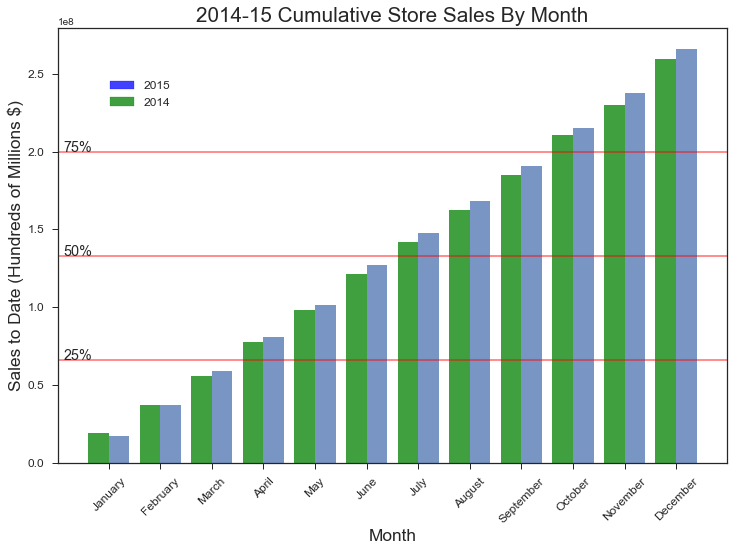

In [427]:
sns.set(style = 'ticks')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ind = np.arange(2,26,2)

_ = plt.bar(ind, cms_sales2014_avg['value'],alpha=0.75,color='g',width=-0.8,align='edge')
_ = plt.bar(ind, cms_sales2015_avg['value'],alpha=0.75,width=0.8,align='edge')

_ = plt.xticks(ind, ('January','February','March','April',
                    'May','June','July','August',
                    'September','October','November','December'),fontsize='medium',rotation=45)

_ = plt.yticks(fontsize='medium')
_ = plt.xlabel('Month',fontsize='x-large')
_ = plt.ylabel('Sales to Date (Hundreds of Millions $)',fontsize='x-large')
_ = plt.title('2014-15 Cumulative Store Sales By Month',fontsize='xx-large')
#_ = plt.suptitle('Quarterly sales align ',fontsize='xx-large')


_ = plt.axhline(y=66476934,c='red',alpha=0.5)
_ = plt.axhline(y=132953869,c='red',alpha=0.5)
_ = plt.axhline(y=199430803,c='red',alpha=0.5)

_ = plt.text(0.25,66500000,'25%',fontsize='large')
_ = plt.text(0.25,133000000,'50%',fontsize='large')
_ = plt.text(0.25,200000000,'75%',fontsize='large')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='green', label='2014',alpha=0.75)
blue_patch = mpatches.Patch(color='blue',label='2015',alpha=0.75)
plt.legend(handles=[blue_patch,red_patch],bbox_to_anchor=(0,1),
           ncol=1, mode="expand", borderaxespad=4,fontsize='medium');

plt.savefig('cumulative1415.jpg')

In [389]:
first3 = storesmonth2015[storesmonth2015['date'].isin(['January','February','March'])]
first3 = pd.merge(first3,y2015.reset_index(),on='storenum')
first3.rename(columns={'sale_dollars_x':'month_sales',
                       'sale_dollars_y':'annual_sales'},inplace=True)
first3 = first3.groupby('storenum').agg({'month_sales':'sum','annual_sales':'mean'})
first3.head()

,month_sales,annual_sales
storenum,,
2106,337166.53,1434369.85
2113,22351.86,85763.42
2130,277764.46,1108184.99
2152,16805.11,72080.36
2178,54411.42,277987.96


In [390]:
first3_14 = storesmonth2014[storesmonth2014['date'].isin(['January','February','March'])]
first3_14 = pd.merge(first3_14,y2014.reset_index(),on='storenum')
first3_14.rename(columns={'sale_dollars_x':'month_sales',
                       'sale_dollars_y':'annual_sales'},inplace=True)
first3_14 = first3_14.groupby('storenum').agg({'month_sales':'sum','annual_sales':'mean'})

first3_14.head()

,month_sales,annual_sales
storenum,,
2106,301342.25,1342161.28
2113,21991.54,99913.51
2130,232979.08,1034376.03
2152,24231.74,94892.90
2178,61699.37,275606.81


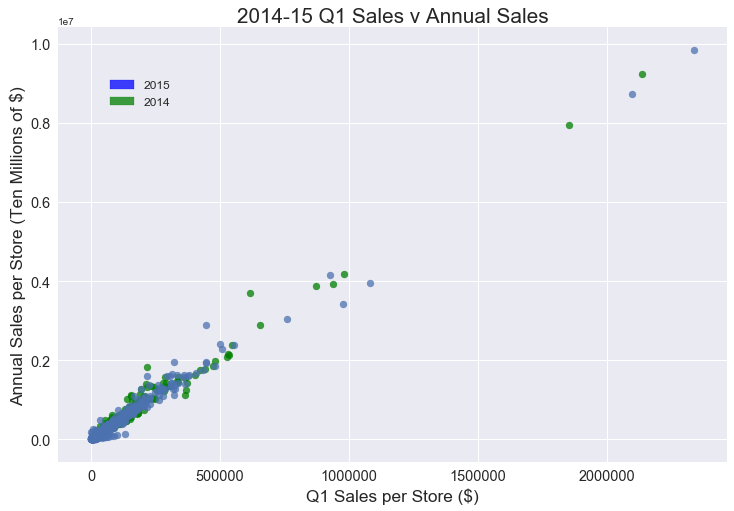

In [391]:
sns.set(style = 'darkgrid')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

#ind = np.arange(2,26,2)

_ = plt.scatter(first3_14['month_sales'],first3_14['annual_sales'],alpha=0.75,color='g')
_ = plt.scatter(q1_2015['month_sales'],q1_2015['annual_sales'],alpha=0.75)

_ = plt.yticks(fontsize='large')
_ = plt.xticks(fontsize='large')
_ = plt.xlabel('Q1 Sales per Store ($)',fontsize='x-large')
_ = plt.ylabel('Annual Sales per Store (Ten Millions of $)',fontsize='x-large')
_ = plt.title('2014-15 Q1 Sales v Annual Sales',fontsize='xx-large')
#_ = plt.suptitle('Quarterly sales align ',fontsize='xx-large')


import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='green', label='2014',alpha=0.75)
blue_patch = mpatches.Patch(color='blue',label='2015',alpha=0.75)
plt.legend(handles=[blue_patch,red_patch],bbox_to_anchor=(0,1),
           ncol=1, mode="expand", borderaxespad=4,fontsize='medium');

plt.savefig('first3_scatter.jpg')

In [392]:
m6_predict_2016 = pd.DataFrame(m6_predict_2016)
ms_sales2016i_X.reset_index(inplace=True)
predicted2016 = ms_sales2016i_X.merge(m6_predict_2016,left_index=True,right_index=True)

countystores16 = test2016[test2016[['county','storenum']].duplicated()==False][['county','storenum']]
predicted2016 = predicted2016.merge(countystores16,on='storenum',how='inner')

In [393]:
predicted2016.head()

,index,storenum,"('sale_dollars', 'February')","('sale_dollars', 'January')","('sale_dollars', 'March')",jf,fm,0,county
0,0,2106,105665.83,102944.29,129193.93,1.087769e+10,1.365138e+10,1.544781e+06,Black Hawk
1,1,2113,6192.17,7194.92,8349.54,4.455217e+07,5.170177e+07,1.057860e+05,Webster
2,2,2130,105375.70,83481.76,118084.81,8.796949e+09,1.244327e+10,1.403949e+06,Black Hawk
3,3,2152,4583.76,4723.99,4444.49,2.165364e+07,2.037248e+07,6.612745e+04,Cerro Gordo
4,4,2178,18131.52,16077.39,24730.99,2.915075e+08,4.484104e+08,2.862377e+05,Allamakee


In [394]:
monthannual2016 = storesmonth2016.groupby('storenum').sum()
monthannual2016.reset_index(inplace=True)
monthannual2016 = monthannual2016.merge(predicted2016,on='storenum')
monthannual2016 = monthannual2016[['storenum','sale_dollars',0]]

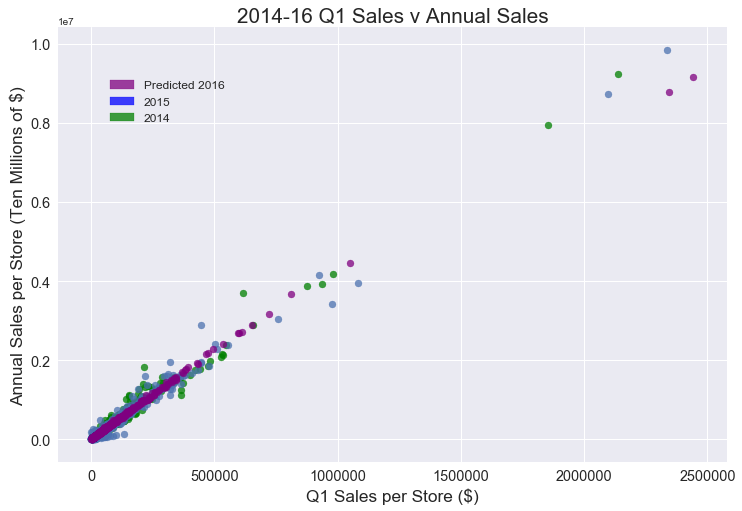

In [395]:
sns.set(style = 'darkgrid')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

#ind = np.arange(2,26,2)

_ = plt.scatter(first3_14['month_sales'],first3_14['annual_sales'],alpha=0.75,color='g')
_ = plt.scatter(q1_2015['month_sales'],q1_2015['annual_sales'],alpha=0.75)
_ = plt.scatter(monthannual2016['sale_dollars'],monthannual2016[0],alpha=0.75,color='purple')

_ = plt.yticks(fontsize='large')
_ = plt.xticks(fontsize='large')
_ = plt.xlabel('Q1 Sales per Store ($)',fontsize='x-large')
_ = plt.ylabel('Annual Sales per Store (Ten Millions of $)',fontsize='x-large')
_ = plt.title('2014-16 Q1 Sales v Annual Sales',fontsize='xx-large')
#_ = plt.suptitle('Quarterly sales align ',fontsize='xx-large')


import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='green', label='2014',alpha=0.75)
blue_patch = mpatches.Patch(color='blue',label='2015',alpha=0.75)
purple_patch = mpatches.Patch(color='purple',label='Predicted 2016',alpha=0.75)
plt.legend(handles=[purple_patch,blue_patch,red_patch],bbox_to_anchor=(0,1),
           ncol=1, mode="expand", borderaxespad=4,fontsize='medium');

plt.savefig('first3_scatter.jpg')

## Overlay 2016 data on 2015

In [396]:
cms_sales2016 = ms_sales2016.copy()
cms_sales2016['January'] = cms_sales2016["('sale_dollars', 'January')"]
cms_sales2016['February'] = cms_sales2016['January'] + cms_sales2016["('sale_dollars', 'February')"]
cms_sales2016['March'] = cms_sales2016['February'] + cms_sales2016["('sale_dollars', 'March')"]

cms_sales2016.drop(["('sale_dollars', 'January')", "('sale_dollars', 'February')", 
                   "('sale_dollars', 'March')"],
                  axis=1,inplace=True)

cms_sales2016.head()

,January,February,March
storenum,,,
2106,102944.29,208610.12,337804.05
2113,7194.92,13387.09,21736.63
2130,83481.76,188857.46,306942.27
2152,4723.99,9307.75,13752.24
2178,16077.39,34208.91,58939.90


In [421]:
cms_sales2016.reset_index(inplace=True)
cms_sales2016_long = pd.melt(cms_sales2016, id_vars=['storenum'])
cms_sales2016_avg = cms_sales2016_long.groupby('variable').sum()
#cms_sales2016_avg.drop('sale_dollars',inplace=True)

In [422]:
#https://stackoverflow.com/questions/30009948/how-to-reorder-indexed-rows-based-on-a-list-in-pandas-data-frame
cms_sales2016_avg = cms_sales2016_avg.reindex(['January','February','March'])

In [423]:
cms_sales2016_avg

,storenum,value
variable,,
January,4958791,18757521.03
February,4958791,41335179.82
March,4958791,64706294.73


In [424]:
cms_sales2015_avg

,storenum,value
variable,,
January,4056875,1.733478e+07
February,4056875,3.742904e+07
March,4056875,5.942831e+07
April,4056875,8.081992e+07
May,4056875,1.015682e+08
June,4056875,1.269385e+08
July,4056875,1.478496e+08
August,4056875,1.685157e+08
September,4056875,1.910354e+08


In [425]:
cms_sales2014_avg

,storenum,value
variable,,
January,3902942,1.920070e+07
February,3902942,3.757579e+07
March,3902942,5.610370e+07
April,3902942,7.779410e+07
May,3902942,9.799102e+07
June,3902942,1.213099e+08
July,3902942,1.421509e+08
August,3902942,1.623484e+08
September,3902942,1.848828e+08


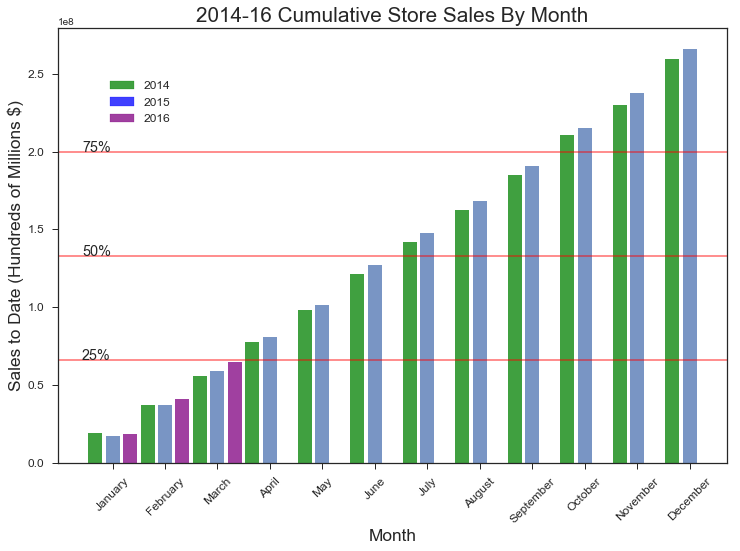

In [428]:
sns.set(style = 'ticks')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

xrange1 = np.arange(1,36,3)
_ = plt.bar(xrange1, cms_sales2014_avg['value'],alpha=0.75,color='g')

xrange2 = np.arange(2,37,3)
_ = plt.bar(xrange2, cms_sales2015_avg['value'],alpha=0.75)

xrange3 = np.arange(3,10,3)
_ = plt.bar(xrange3, cms_sales2016_avg['value'],alpha=0.75,color='purple')


_ = plt.xticks(xrange2, ('January','February','March','April',
                    'May','June','July','August',
                    'September','October','November','December'),fontsize='medium',rotation=45)

_ = plt.yticks(fontsize='medium')
_ = plt.xlabel('Month',fontsize='x-large')
_ = plt.ylabel('Sales to Date (Hundreds of Millions $)',fontsize='x-large')
_ = plt.title('2014-16 Cumulative Store Sales By Month',fontsize='xx-large')
#_ = plt.suptitle('Quarterly sales align ',fontsize='xx-large')


_ = plt.axhline(y=66476934,c='red',alpha=0.5)
_ = plt.axhline(y=132953869,c='red',alpha=0.5)
_ = plt.axhline(y=199430803,c='red',alpha=0.5)

_ = plt.text(0.25,66500000,'25%',fontsize='large')
_ = plt.text(0.25,133000000,'50%',fontsize='large')
_ = plt.text(0.25,200000000,'75%',fontsize='large')

import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='2014',alpha=0.75)
blue_patch = mpatches.Patch(color='blue',label='2015',alpha=0.75)
purple_patch = mpatches.Patch(color='purple',label='2016',alpha=0.75)

plt.legend(handles=[green_patch,blue_patch,purple_patch],bbox_to_anchor=(0,1),
           ncol=1, mode="expand", borderaxespad=4,fontsize='medium');

plt.savefig('cumulative1416.jpg')